# Impacts of Demographic Factors on Voter Turnout in the 2020 Election
## By: Amir Voloshin, Surabhi Sharma, Simon Lee, Joshua Price

# Introduction

During Elections, party leaders and candidates are in favor of high voter turnout. Given a high citizen population, candidates want to know if these citizens are voting. What factors constitute a high voter turnout? In this report, we analyze the different factors that correlate voter turnout amongst 4 different states: New Jersey, Nevada, Washington, and Alaska. These states were chosen since they have a diverse population and the data provides abundant information regarding voter statistics. Amongst the many factors that count for turnout in elections, the relationship between voter turnout and income level, house ownership cost, homeownership at the county level, and marital status were explored and analyzed. Specifically, the report looks into the impact of the following prompts:

Is there disparity in voter turnout among households based on income level? 
How does house ownership and/or housing cost impact voting turnout? 
Do counties with higher home ownership have higher voter turnout? 
What is the difference of voter turnout amongst couples with and without children?

In order to delve into these queries and form conclusions, a range of statistical and data visualization methods will be employed to explore the impact of these factors and voter turnout.
The intent of this project is to create a model and conclusion on how these demographic factors can help candidates in their future elections strive to improve equity in their electoral process.


## Libraries

In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.ml.feature import RFormula
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import random
%matplotlib inline
plt.style.use('ggplot')
from pyspark.sql.functions import col
from pyspark.sql.functions import count
from pyspark.sql.functions import when
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import avg
from sklearn.model_selection import train_test_split
from sklearn import metrics
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("your_app_name").getOrCreate()

## Loading in the Data

In [14]:
# Loading in Alaska Data
df_ak = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load("gs://135final_data_bucket/VM2Uniform--AK--2021-02-03.tab")

# Loading in Nevada Data
df_nv = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load("gs://135final_data_bucket/VM2Uniform--NV--2021-06-13.tab")


# Loading in New Jersey Data
df_nj = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load("gs://135final_data_bucket/VM2Uniform--NJ--2021-03-11.tab")

# Loading in Washington Data
df_wa = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load("gs://135final_data_bucket/VM2Uniform--WA--2020-12-09.tab")

## Caching so dataframes will be in cluster memory

In [15]:
# Repartitioning and Configuring the data sets
df_ak = df_ak.repartition(20)
spark.conf.set("spark.sql.shuffle.partitions", "20")

df_nv = df_nv.repartition(20)
spark.conf.set("spark.sql.shuffle.partitions", "20")

df_nj = df_nj.repartition(20)
spark.conf.set("spark.sql.shuffle.partitions", "20")

df_wa = df_wa.repartition(20)
spark.conf.set("spark.sql.shuffle.partitions", "20")

# Caching the DataFrames
df_ak.cache();
df_nv.cache();
df_nj.cache();
df_wa.cache();

23/03/22 04:20:23 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Motivating this Project

In [16]:
# Subsetting data for total voters and non voters
# Alaska
general_2020_ak = df_ak.select('General_2020').fillna('N').toPandas()

# Nevada
general_2020_nv = df_nv.select('General_2020').fillna('N').toPandas()

In [121]:
# New Jersey
general_2020_nj = df_nj.select('General_2020').fillna('N').toPandas()

# Washington
general_2020_wa = df_wa.select('General_2020').fillna('N').toPandas()

In [28]:
voter_data = {'WA Yes': len(general_2020_wa[general_2020_wa['General_2020'] == 'Y']), 'WA No': len(general_2020_wa[general_2020_wa['General_2020'] == 'N']), 
              'NJ Yes': len(general_2020_nj[general_2020_nj['General_2020'] == 'Y']), 'NJ No': len(general_2020_nj[general_2020_nj['General_2020'] == 'N']),
              'NV Yes': len(general_2020_nv[general_2020_nv['General_2020'] == 'Y']), 'NV No': len(general_2020_nv[general_2020_nv['General_2020'] == 'N']),
              'AK Yes': len(general_2020_ak[general_2020_ak['General_2020'] == 'Y']), 'AK No': len(general_2020_ak[general_2020_ak['General_2020'] == 'N'])}
x_voter = list(voter_data.keys())
y_voter = list(voter_data.values())

<function matplotlib.pyplot.show(close=None, block=None)>

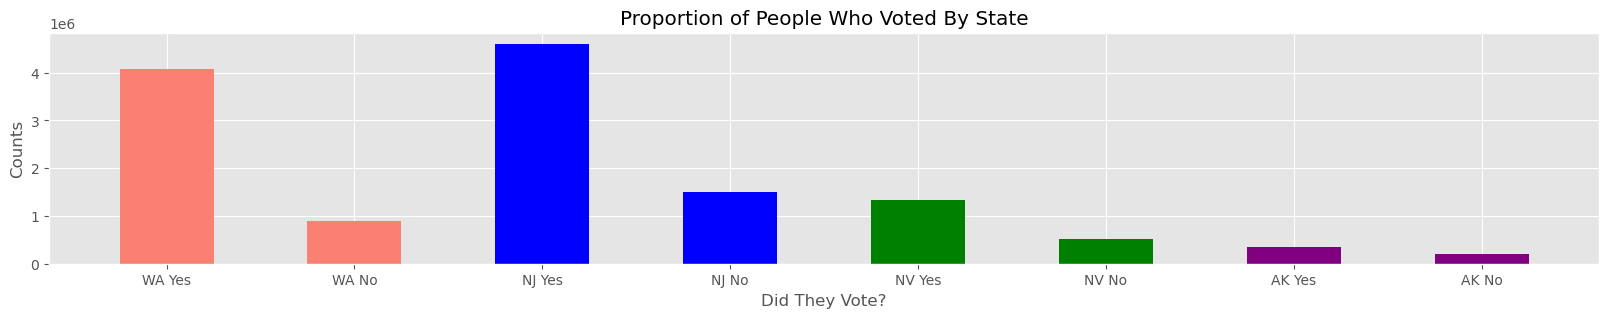

In [122]:
plt.bar(x_voter, y_voter, color = ['salmon', 'salmon', 'blue', 'blue', 'green', 'green', 'purple', 'purple'], width = 0.5)
plt.xlabel('Did They Vote?')
plt.ylabel('Counts')
plt.title('Proportion of People Who Voted By State')
plt.show

As we see in the graph above, in each state there is a signifcant amount of people who do not vote and we are curious to know why people are not voting. Do the wealthier tend to vote more? Do home owners tend to vote more? Does the location where you live determine if you will vote or not? These are some questions about voters among many others, which can help a candidate in their campaign. For example, if a candidate notices people with low income tend to not vote, they may want to target those people when campaigning to gain votes. 

# Home Owner vs Renter Voter Turnout 

In [39]:
# Subsetting the data for Home Owner or Renter
# Alaska
ak_own = df_ak.select('CommercialDataLL_Home_Owner_Or_Renter').na.drop().where(F.col('CommercialDataLL_Home_Owner_Or_Renter') == 'Likely Homeowner').count() # Homeowners
ak_rent = df_ak.select('CommercialDataLL_Home_Owner_Or_Renter').na.drop().where(F.col('CommercialDataLL_Home_Owner_Or_Renter') == 'Likely Renter').count() # Renters

In [40]:
# Nevada
nv_own = df_nv.select('CommercialDataLL_Home_Owner_Or_Renter').na.drop().where(F.col('CommercialDataLL_Home_Owner_Or_Renter') == 'Likely Homeowner').count() # Homeowners
nv_rent = df_nv.select('CommercialDataLL_Home_Owner_Or_Renter').na.drop().where(F.col('CommercialDataLL_Home_Owner_Or_Renter') == 'Likely Renter').count() # Renters


In [41]:
# New Jersey
nj_own = df_nj.select('CommercialDataLL_Home_Owner_Or_Renter').na.drop().where(F.col('CommercialDataLL_Home_Owner_Or_Renter') == 'Likely Homeowner').count() # Homeowners
nj_rent = df_nj.select('CommercialDataLL_Home_Owner_Or_Renter').na.drop().where(F.col('CommercialDataLL_Home_Owner_Or_Renter') == 'Likely Renter').count() # Renters

In [42]:
# Washington
wa_own = df_wa.select('CommercialDataLL_Home_Owner_Or_Renter').na.drop().where(F.col('CommercialDataLL_Home_Owner_Or_Renter') == 'Likely Homeowner').count() # Homeowners
wa_rent = df_wa.select('CommercialDataLL_Home_Owner_Or_Renter').na.drop().where(F.col('CommercialDataLL_Home_Owner_Or_Renter') == 'Likely Renter').count() # Renters

In [43]:
# Configuring for plot
own_rent = {'AK Homeowner': ak_own, ' AK Renter': ak_rent, 'NV Homeowner': nv_own, 'NV Renter': nv_rent, 'NJ Homeowner': nj_own, 'NJ Renter': nj_rent,
            'WA Homeowner': wa_own, 'WA Renter': wa_rent}

# configuring axes
x_own_rent = list(own_rent.keys())
y_own_rent = list(own_rent.values()) 

<function matplotlib.pyplot.show(close=None, block=None)>

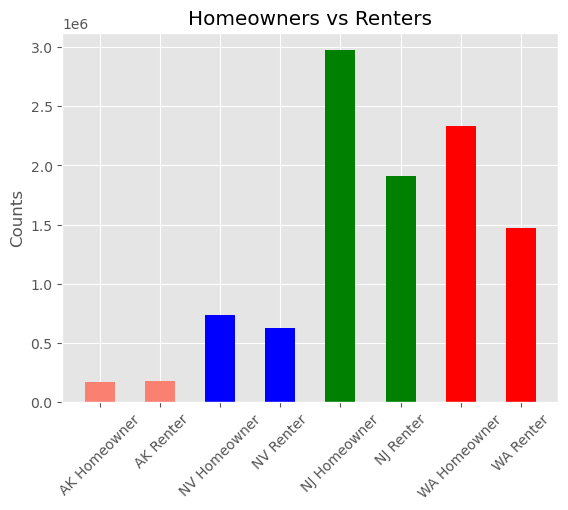

In [44]:
# Plot
plt.bar(x_own_rent, y_own_rent, color = ['salmon', 'salmon', 'blue', 'blue', 'green', 'green', 'red', 'red'], width = 0.5)
plt.ylabel('Counts')
plt.xticks(rotation = 45) 
plt.title('Homeowners vs Renters')
plt.show

In all the states examined other than Alaska, there are more home owners than renters. 

In [45]:
# Subsetting data
# Alaska
# Homeowner and Voter
own_voted_ak = df_ak.select('CommercialDataLL_Home_Owner_Or_Renter', 'General_2020').filter((df_ak['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner') & (df_ak['General_2020'] == 'Y')).count()

# Renter and Voter
rent_voted_ak = df_ak.select('CommercialDataLL_Home_Owner_Or_Renter', 'General_2020').filter((df_ak['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter') & (df_ak['General_2020'] == 'Y')).count()

# Homeowner and Non-Voter
z = df_ak.select('CommercialDataLL_Home_Owner_Or_Renter', 'General_2020').fillna('N') 
own_non_voter_ak = z.filter((z['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner') & (z['General_2020'] == 'N')).count()

# Renter and Non-Voter 
rent_non_voter_ak = z.filter((z['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter') & (z['General_2020'] == 'N')).count()

In [46]:
# Nevada
# Homeowner and Voter
own_voted_nv = df_nv.select('CommercialDataLL_Home_Owner_Or_Renter', 'General_2020').filter((df_nv['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner') & (df_nv['General_2020'] == 'Y')).count()

# Renter and Voter
rent_voted_nv = df_nv.select('CommercialDataLL_Home_Owner_Or_Renter', 'General_2020').filter((df_nv['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter') & (df_nv['General_2020'] == 'Y')).count()

# Homeowner and Non-Voter
z_nv = df_nv.select('CommercialDataLL_Home_Owner_Or_Renter', 'General_2020').fillna('N') 
own_non_voter_nv = z_nv.filter((z_nv['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner') & (z_nv['General_2020'] == 'N')).count()

# Renter and Non-Voter 
rent_non_voter_nv = z_nv.filter((z_nv['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter') & (z_nv['General_2020'] == 'N')).count()

In [47]:
# New Jersey
# Homeowner and Voter
own_voted_nj = df_nj.select('CommercialDataLL_Home_Owner_Or_Renter', 'General_2020').filter((df_nj['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner') & (df_nj['General_2020'] == 'Y')).count()

# Renter and Voter
rent_voted_nj = df_nj.select('CommercialDataLL_Home_Owner_Or_Renter', 'General_2020').filter((df_nj['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter') & (df_nj['General_2020'] == 'Y')).count()

# Homeowner and Non-Voter
z_nj = df_nj.select('CommercialDataLL_Home_Owner_Or_Renter', 'General_2020').fillna('N') 
own_non_voter_nj = z_nj.filter((z_nj['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner') & (z_nj['General_2020'] == 'N')).count()

# Renter and Non-Voter 
rent_non_voter_nj = z_nj.filter((z_nj['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter') & (z_nj['General_2020'] == 'N')).count()

In [48]:
# Washington
# Homeowner and Voter
own_voted_wa = df_wa.select('CommercialDataLL_Home_Owner_Or_Renter', 'General_2020').filter((df_wa['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner') & (df_wa['General_2020'] == 'Y')).count()

# Renter and Voter
rent_voted_wa = df_wa.select('CommercialDataLL_Home_Owner_Or_Renter', 'General_2020').filter((df_wa['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter') & (df_wa['General_2020'] == 'Y')).count()

# Homeowner and Non-Voter
z_wa = df_wa.select('CommercialDataLL_Home_Owner_Or_Renter', 'General_2020').fillna('N') 
own_non_voter_wa = z_wa.filter((z_wa['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner') & (z_wa['General_2020'] == 'N')).count()

# Renter and Non-Voter 
rent_non_voter_wa = z_wa.filter((z_wa['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter') & (z_wa['General_2020'] == 'N')).count()

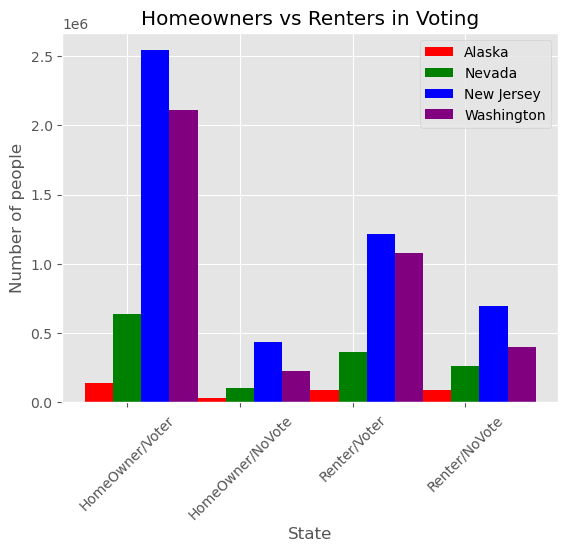

In [49]:
# Plotting 
N = 4
ind = np.arange(N) 
width = 0.25
  
xvals = [own_voted_ak, own_non_voter_ak, rent_voted_ak, rent_non_voter_ak]
ak = plt.bar(ind, xvals, width, color = 'red')
  
yvals = [own_voted_nv, own_non_voter_nv, rent_voted_nv, rent_non_voter_nv]
nv = plt.bar(ind+width, yvals, width, color = 'green')
  
zvals = [own_voted_nj, own_non_voter_nj, rent_voted_nj, rent_non_voter_nj]
nj = plt.bar(ind+width*2, zvals, width, color = 'blue')

nvals = [own_voted_wa, own_non_voter_wa, rent_voted_wa, rent_non_voter_wa]
wa = plt.bar(ind+width*3, nvals, width, color = 'purple')
plt.xlabel('State')
plt.ylabel('Number of people')
plt.title('Homeowners vs Renters in Voting')
  
plt.xticks(ind+width,['HomeOwner/Voter', 'HomeOwner/NoVote', 'Renter/Voter', 'Renter/NoVote'], rotation = 45)
plt.legend((ak, nv, nj, wa), ('Alaska', 'Nevada', 'New Jersey', 'Washington'))
plt.show()


In the graph above all the Renter/Novote bars are taller than the HomeOwner/NoVote bars. This indicates that there are more renters who do not vote than homeowners who do not vote. In other words, homeowners tend to vote more than renters. 

## Is there disparity among house prices and voters? 

In [32]:
# Voter housing prices Alaska
price_voted = df_ak.select('CommercialData_HomePurchasePrice', 'General_2020').fillna('N').filter((df_ak['CommercialData_HomePurchasePrice'] != 'N') & 
                                                                                                  (df_ak['General_2020'] == 'Y')).toPandas()
# Non-Voter housing prices
price_novote_raw = df_ak.select('CommercialData_HomePurchasePrice', 'General_2020').fillna('N')
price_novote = price_novote_raw.filter((price_novote_raw['CommercialData_HomePurchasePrice'] != 'N') & (price_novote_raw['General_2020'] == 'N')).toPandas()

# Voter housing prices
price_voted_nv = df_nv.select('CommercialData_HomePurchasePrice', 'General_2020').fillna('N').filter((df_nv['CommercialData_HomePurchasePrice'] != 'N') & 
                                                                                                  (df_nv['General_2020'] == 'Y')).toPandas()
# Non-Voter housing prices Nevada
price_novote_raw_nv = df_nv.select('CommercialData_HomePurchasePrice', 'General_2020').fillna('N')
price_novote_nv = price_novote_raw_nv.filter((price_novote_raw_nv['CommercialData_HomePurchasePrice'] != 'N') & (price_novote_raw_nv['General_2020'] == 'N')).toPandas()

# Voter housing prices New Jersey
price_voted_nj = df_nj.select('CommercialData_HomePurchasePrice', 'General_2020').fillna('N').filter((df_nj['CommercialData_HomePurchasePrice'] != 'N') & 
                                                                                                  (df_nj['General_2020'] == 'Y')).toPandas()
# Non-Voter housing prices
price_novote_raw_nj = df_nj.select('CommercialData_HomePurchasePrice', 'General_2020').fillna('N')
price_novote_nj = price_novote_raw_nj.filter((price_novote_raw_nj['CommercialData_HomePurchasePrice'] != 'N') & (price_novote_raw_nj['General_2020'] == 'N')).toPandas()

# Voter housing prices Washington
price_voted_wa = df_wa.select('CommercialData_HomePurchasePrice', 'General_2020').fillna('N').filter((df_wa['CommercialData_HomePurchasePrice'] != 'N') & 
                                                                                                  (df_wa['General_2020'] == 'Y')).toPandas()
# Non-Voter housing prices
price_novote_raw_wa = df_wa.select('CommercialData_HomePurchasePrice', 'General_2020').fillna('N')
price_novote_wa = price_novote_raw_wa.filter((price_novote_raw_wa['CommercialData_HomePurchasePrice'] != 'N') & (price_novote_raw_wa['General_2020'] == 'N')).toPandas()

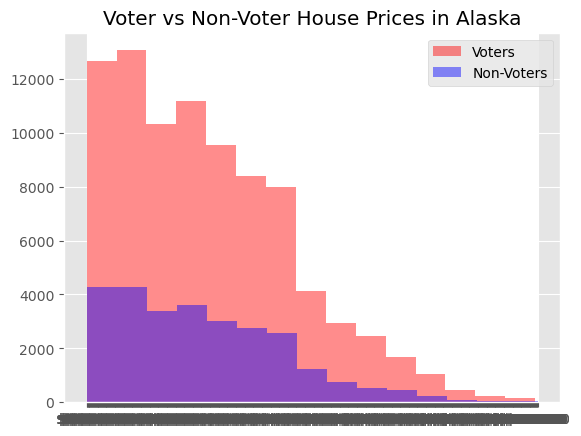

In [50]:
# Histogram of Voter House Price vs Non-Voter Alaska
plt.hist(price_voted['CommercialData_HomePurchasePrice'], bins = 15, alpha = 0.45, color = 'red')
plt.hist(price_novote['CommercialData_HomePurchasePrice'], bins = 15, alpha = 0.45, color = 'blue')
plt.title("Voter vs Non-Voter House Prices in Alaska")
plt.legend(['Voters', 'Non-Voters'])
# plt.setp(labels, rotation=90)
plt.show()

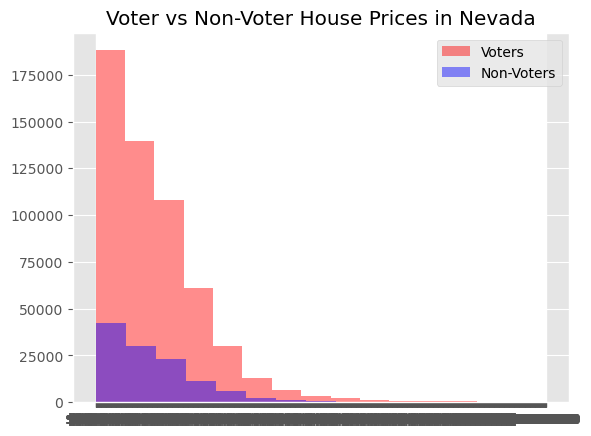

In [51]:
# Histogram of Voter House Price vs Non-Voter Nevada
plt.hist(price_voted_nv['CommercialData_HomePurchasePrice'], bins = 15, alpha = 0.45, color = 'red')
plt.hist(price_novote_nv['CommercialData_HomePurchasePrice'], bins = 15, alpha = 0.45, color = 'blue')
plt.title("Voter vs Non-Voter House Prices in Nevada")
plt.legend(['Voters', 'Non-Voters'])
plt.show()

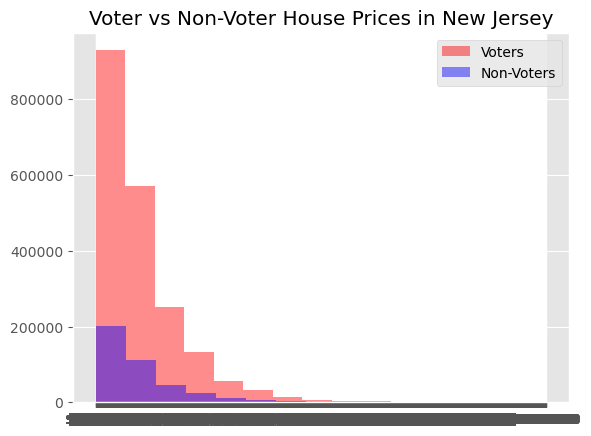

In [52]:
# Histogram of Voter House Price vs Non-Voter
plt.hist(price_voted_nj['CommercialData_HomePurchasePrice'], bins = 15, alpha = 0.45, color = 'red')
plt.hist(price_novote_nj['CommercialData_HomePurchasePrice'], bins = 15, alpha = 0.45, color = 'blue')
plt.title("Voter vs Non-Voter House Prices in New Jersey")
plt.legend(['Voters', 'Non-Voters'])
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)
plt.show()

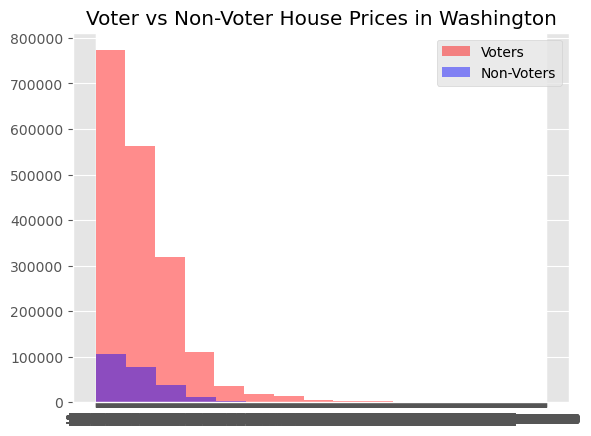

In [53]:
# Histogram of Voter House Price vs Non-Voter
plt.hist(price_voted_wa['CommercialData_HomePurchasePrice'], bins = 15, alpha = 0.45, color = 'red')
plt.hist(price_novote_wa['CommercialData_HomePurchasePrice'], bins = 15, alpha = 0.45, color = 'blue')
plt.title("Voter vs Non-Voter House Prices in Washington")
plt.legend(['Voters', 'Non-Voters'])
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)
plt.show()

From the histograms above we can see that there are more voters, but the house-price range of voters to non-voters is the same. In other words, there is not a specific price range of houses for which there are no non-voters or no voters among the four states. 

# Counties Voter Turnout based on Home Ownership

### Pre-processing for Home Owners and Voter Turnout

In [ ]:
#new jersey dataframe
NJ_county = df_nj[['County','CommercialDataLL_Home_Owner_Or_Renter','General_2020']].filter((df_nj['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner'))
NJ_county = NJ_county.toPandas()

NJ_county_home = NJ_county.value_counts().reset_index()
NJ_county_home.columns = ['County', 'CommercialDataLL_Home_Owner_Or_Renter', 'General_2020', 'Counts']
NJ_county_home = NJ_county_home.sort_values('County')
NJ_county_home = NJ_county_home.set_index('County')

In [ ]:
#Alaska dataframe

AK_county = df_ak[['County','CommercialDataLL_Home_Owner_Or_Renter','General_2020']].filter((df_ak['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner'))
AK_county = AK_county.toPandas()

AK_county_home = AK_county.value_counts().reset_index()
AK_county_home.columns = ['County', 'CommercialDataLL_Home_Owner_Or_Renter', 'General_2020', 'Counts']
AK_county_home = AK_county_home.sort_values('County')
AK_county_home = AK_county_home.set_index('County')

In [ ]:
#nevada dataframe

NV_county = df_nv[['County','CommercialDataLL_Home_Owner_Or_Renter','General_2020']].filter((df_nv['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner'))
NV_county = NV_county.toPandas()

NV_county_home = NV_county.value_counts().reset_index()
NV_county_home.columns = ['County', 'CommercialDataLL_Home_Owner_Or_Renter', 'General_2020', 'Counts']
NV_county_home = NV_county_home.sort_values('County')
NV_county_home = NV_county_home.set_index('County')

In [ ]:
#Washington dataframe
WA_county = df_wa[['County','CommercialDataLL_Home_Owner_Or_Renter','General_2020']].filter((df_wa['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner'))
WA_county = WA_county.toPandas()

WA_county_home = WA_county.value_counts().reset_index()
WA_county_home.columns = ['County', 'CommercialDataLL_Home_Owner_Or_Renter', 'General_2020', 'Counts']
WA_county_home = WA_county_home.sort_values('County')
WA_county_home = WA_county_home.set_index('County')

### Pre-processing County and Voter Turnout

In [59]:
#new jersey voting dataframe

NJ_county_vote = df_nj[['County','General_2020']].filter((df_nj['General_2020'] == 'Y'))
NJ_county_vote = NJ_county_vote.toPandas()

NJ_county_voter = NJ_county_vote.value_counts().reset_index()
NJ_county_voter.columns = ['County', 'General_2020', 'Counts']
NJ_county_voter = NJ_county_voter.sort_values('County')
NJ_county_voter = NJ_county_voter.set_index('County')
NJ_county_voter;

In [60]:
#Alaska voting dataframe

AK_county_vote = df_ak[['County','General_2020']].filter((df_ak['General_2020'] == 'Y'))
AK_county_vote = AK_county_vote.toPandas()

AK_county_voter = AK_county_vote.value_counts().reset_index()
AK_county_voter.columns = ['County', 'General_2020', 'Counts']
AK_county_voter = AK_county_voter.sort_values('County')
AK_county_voter = AK_county_voter.set_index('County')
AK_county_voter;

In [61]:
#Nevada voting dataframe

NV_county_vote = df_nv[['County','General_2020']].filter((df_nv['General_2020'] == 'Y'))
NV_county_vote = NV_county_vote.toPandas()

NV_county_voter = NV_county_vote.value_counts().reset_index()
NV_county_voter.columns = ['County', 'General_2020', 'Counts']
NV_county_voter = NV_county_voter.sort_values('County')
NV_county_voter = NV_county_voter.set_index('County')
NV_county_voter;

In [62]:
#Washington voting dataframe
WA_county_vote = df_wa[['County','General_2020']].filter((df_wa['General_2020'] == 'Y'))
WA_county_vote = WA_county_vote.toPandas()

WA_county_voter = WA_county_vote.value_counts().reset_index()
WA_county_voter.columns = ['County', 'General_2020', 'Counts']
WA_county_voter = WA_county_voter.sort_values('County')
WA_county_voter = WA_county_voter.set_index('County')
WA_county_voter;

<AxesSubplot:xlabel='County'>

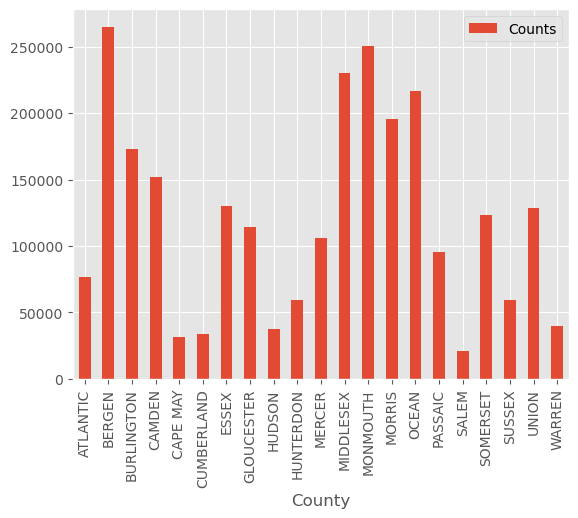

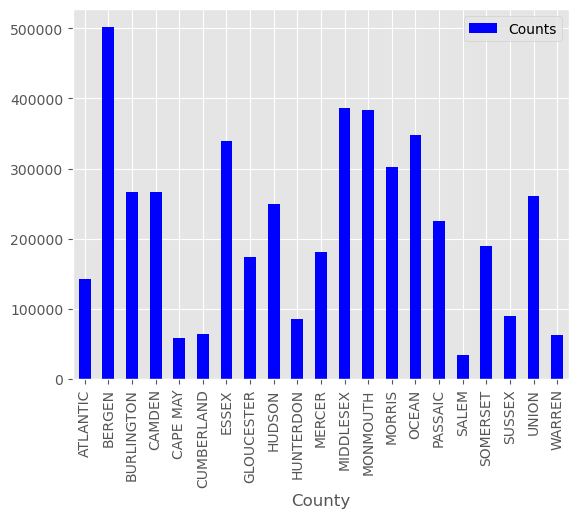

In [64]:
# New Jersey homeowner and voter turnout plot side by side 

NJ_county_home = NJ_county_home.reset_index()

NJ_county_home.plot(x ='County', y = ['Counts'], kind = 'bar')

NJ_county_voter = NJ_county_voter.reset_index()

NJ_county_voter.plot(x ='County', y = ['Counts'], kind = 'bar', color ='blue')

From the results of both plots, it is clear that the highest homeowner ship highest voter turn out is in Bergen county

<AxesSubplot:xlabel='County'>

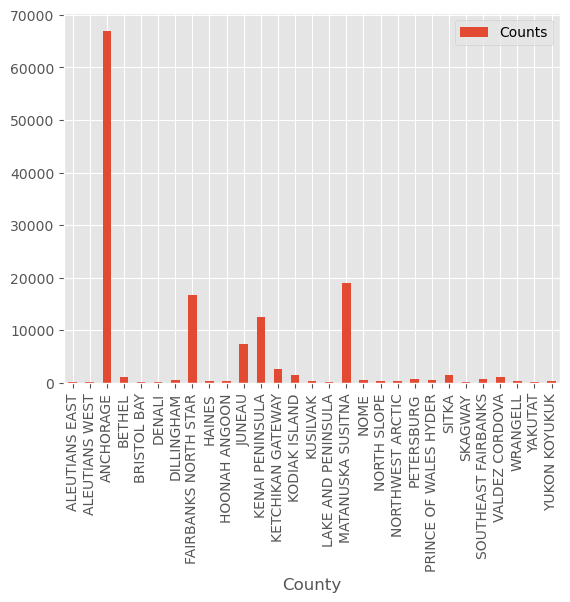

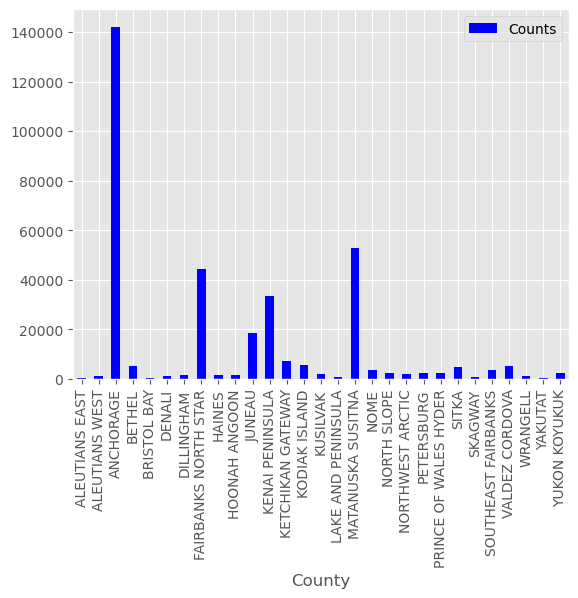

In [65]:
# Alaska homeowner and voter turnout plot side by side 
AK_county_home = AK_county_home.reset_index()

AK_county_home.plot(x ='County', y = ['Counts'], kind = 'bar')

AK_county_voter = AK_county_voter.reset_index()

AK_county_voter.plot(x ='County', y = ['Counts'], kind = 'bar', color ='blue')

From the results of both plots, it is clear that the highest homeowner ship highest voter turn out is in Anchorage county

<AxesSubplot:xlabel='County'>

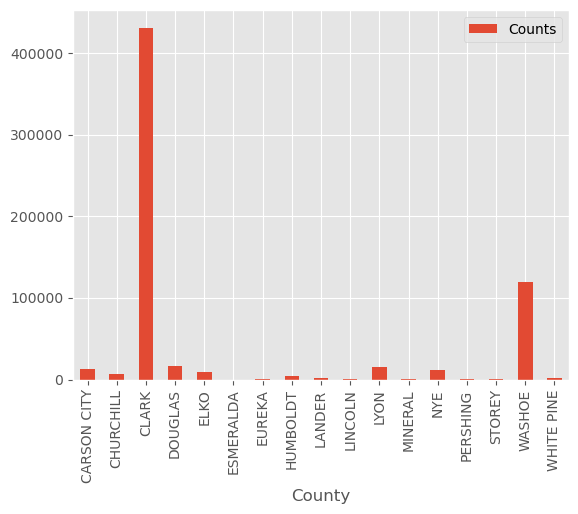

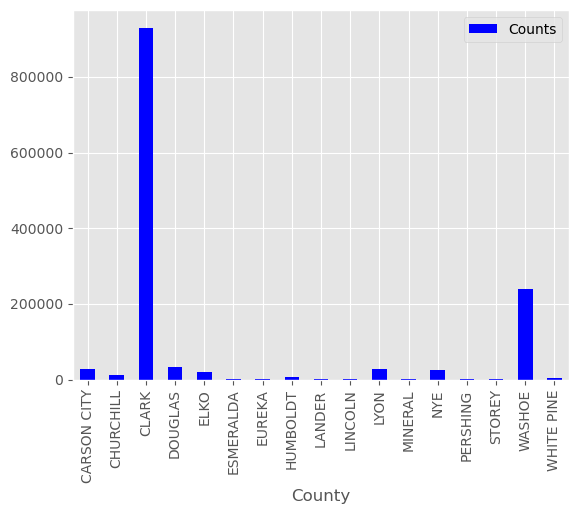

In [66]:
# Nevada homeowner and voter turnout plot side by side 
NV_county_home = NV_county_home.reset_index()

NV_county_home.plot(x ='County', y = ['Counts'], kind = 'bar')

NV_county_voter = NV_county_voter.reset_index()

NV_county_voter.plot(x ='County', y = ['Counts'], kind = 'bar', color ='blue')

From the results of both plots, it is clear that the highest homeowner ship highest voter turn out is in Clark county

<AxesSubplot:xlabel='County'>

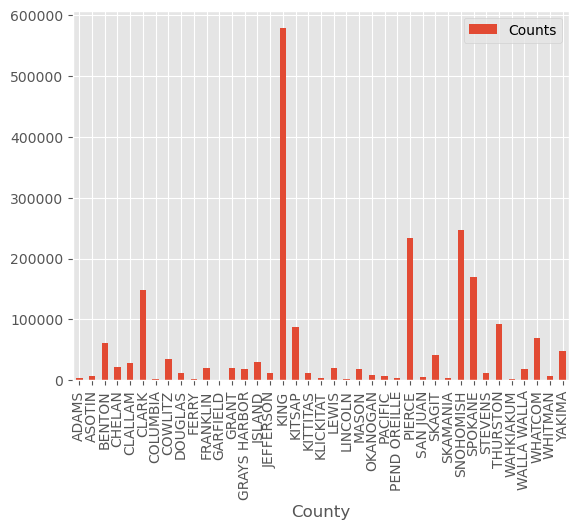

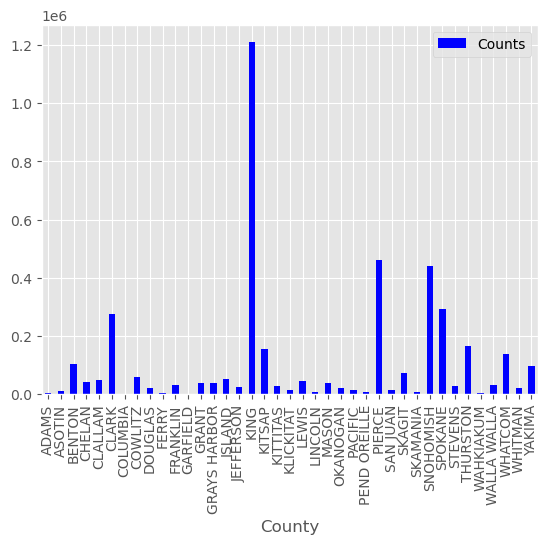

In [68]:
# Washington homeowner and voter turnout plot side by side 
WA_county_home = WA_county_home.reset_index()

WA_county_home.plot(x ='County', y = ['Counts'], kind = 'bar')

WA_county_voter = WA_county_voter.reset_index()

WA_county_voter.plot(x ='County', y = ['Counts'], kind = 'bar', color ='blue')

From the results of both plots, it is clear that the highest homeowner ship highest voter turn out is in King county

# Income and Voter Turnout

First let's take a brief look at some of the relevant variables we will be using. To save time, let's look at the variables for the Alaska data frame, which is the smallest out of our 4 options

In [69]:
df_ak.select('CommercialData_EstimatedHHIncome').show(20)
df_ak.select('CommercialData_EstimatedHHIncomeAmount').show(20)
df_ak.select('General_2020').show(20)

+--------------------------------+
|CommercialData_EstimatedHHIncome|
+--------------------------------+
|                  $100000-124999|
|                    $75000-99999|
|                    $75000-99999|
|                    $75000-99999|
|                    $75000-99999|
|                    $75000-99999|
|                  $100000-124999|
|                    $35000-49999|
|                  $100000-124999|
|                    $75000-99999|
|                  $125000-149999|
|                    $75000-99999|
|                  $125000-149999|
|                        $250000+|
|                  $100000-124999|
|                  $125000-149999|
|                            null|
|                    $35000-49999|
|                    $25000-34999|
|                  $125000-149999|
+--------------------------------+
only showing top 20 rows

+--------------------------------------+
|CommercialData_EstimatedHHIncomeAmount|
+--------------------------------------+
|          

Just from looking at the Alaska data, it seems that there is a lot of null values in CommercialData_EstimatedHHIncome. Since the datasets used are so big, it's probably okay to just exclude those null datapoints and look at the ones that have data recorded in them. The null values in General_2020 will be treated as they didn't vote

In [70]:
distinct_values = df_ak.select(col("CommercialData_EstimatedHHIncome")).distinct().collect()
print(distinct_values)

[Row(CommercialData_EstimatedHHIncome='$175000-199999'), Row(CommercialData_EstimatedHHIncome=None), Row(CommercialData_EstimatedHHIncome='$75000-99999'), Row(CommercialData_EstimatedHHIncome='$25000-34999'), Row(CommercialData_EstimatedHHIncome='$250000+'), Row(CommercialData_EstimatedHHIncome='$200000-249999'), Row(CommercialData_EstimatedHHIncome='$1000-14999'), Row(CommercialData_EstimatedHHIncome='$100000-124999'), Row(CommercialData_EstimatedHHIncome='$35000-49999'), Row(CommercialData_EstimatedHHIncome='$15000-24999'), Row(CommercialData_EstimatedHHIncome='$150000-174999'), Row(CommercialData_EstimatedHHIncome='$125000-149999'), Row(CommercialData_EstimatedHHIncome='$50000-74999')]


CommercialData_EstimatedHHIncome seems to be a classification variable used for different ranges of income. Conveniently, let's use these distinct_values as the ranges for the plots

## Plots

Let's take a look at the different plots for income level and whether the person voted or not. The process is the same for every state. First, create a new data frame as to not mess with the original dataset. The new data frame changes the CommercialData_EstimatedHHIncomeAmount which is the yearly income amount for each person and changes it to an int. Then we make a stacked bar chart of voted/didn't vote for different sections of income levels. The income levels in this case is the distinct values of CommercialData_EstimatedHHIncome. The General_2020 column in the data frame contains whether or not they voted.

# Alaska

In [71]:
# cleaned is changing the string type to an int. And also General_2020 which contains null for didn't vote so we will change that to "N" for computing
df_ak_cleaned = df_ak.filter(col("CommercialData_EstimatedHHIncomeAmount").isNotNull()) \
                     .withColumn("CommercialData_EstimatedHHIncomeAmount",
                                 regexp_replace(col("CommercialData_EstimatedHHIncomeAmount"), "[\$,]", "").cast("int")) \
                     .na.fill("N", subset=["General_2020"])
# these are the amounts for each range of income for alaska that voted
ak_i1y = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 0) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 14999) & (df_ak_cleaned['General_2020'] == 'Y')).count()
ak_i2y = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 15000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 24999) & (df_ak_cleaned['General_2020'] == 'Y')).count()
ak_i3y = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 25000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 34999) & (df_ak_cleaned['General_2020'] == 'Y')).count()
ak_i4y = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 35000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 49999) & (df_ak_cleaned['General_2020'] == 'Y')).count()
ak_i5y = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 50000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 74999) & (df_ak_cleaned['General_2020'] == 'Y')).count()
ak_i6y = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 75000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 99999) & (df_ak_cleaned['General_2020'] == 'Y')).count()
ak_i7y = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 100000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 124999) & (df_ak_cleaned['General_2020'] == 'Y')).count()
ak_i8y = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 125000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 149999) & (df_ak_cleaned['General_2020'] == 'Y')).count()
ak_i9y = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 150000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 174999) & (df_ak_cleaned['General_2020'] == 'Y')).count()
ak_i10y = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 175000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 199999) & (df_ak_cleaned['General_2020'] == 'Y')).count()
ak_i11y = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 200000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 249999) & (df_ak_cleaned['General_2020'] == 'Y')).count()
ak_i12y = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 250000) & (df_ak_cleaned['General_2020'] == 'Y')).count()

In [72]:
# these are the amounts for each range of income for alaska that didn't vote
ak_i1n = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 0) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 14999) & (df_ak_cleaned['General_2020'] == 'N')).count()
ak_i2n = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 15000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 24999) & (df_ak_cleaned['General_2020'] == 'N')).count()
ak_i3n = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 25000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 34999) & (df_ak_cleaned['General_2020'] == 'N')).count()
ak_i4n = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 35000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 49999) & (df_ak_cleaned['General_2020'] == 'N')).count()
ak_i5n = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 50000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 74999) & (df_ak_cleaned['General_2020'] == 'N')).count()
ak_i6n = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 75000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 99999) & (df_ak_cleaned['General_2020'] == 'N')).count()
ak_i7n = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 100000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 124999) & (df_ak_cleaned['General_2020'] == 'N')).count()
ak_i8n = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 125000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 149999) & (df_ak_cleaned['General_2020'] == 'N')).count()
ak_i9n = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 150000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 174999) & (df_ak_cleaned['General_2020'] == 'N')).count()
ak_i10n = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 175000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 199999) & (df_ak_cleaned['General_2020'] == 'N')).count()
ak_i11n = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 200000) & (df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 249999) & (df_ak_cleaned['General_2020'] == 'N')).count()
ak_i12n = df_ak_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_ak_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 250000) & (df_ak_cleaned['General_2020'] == 'Y')).count()

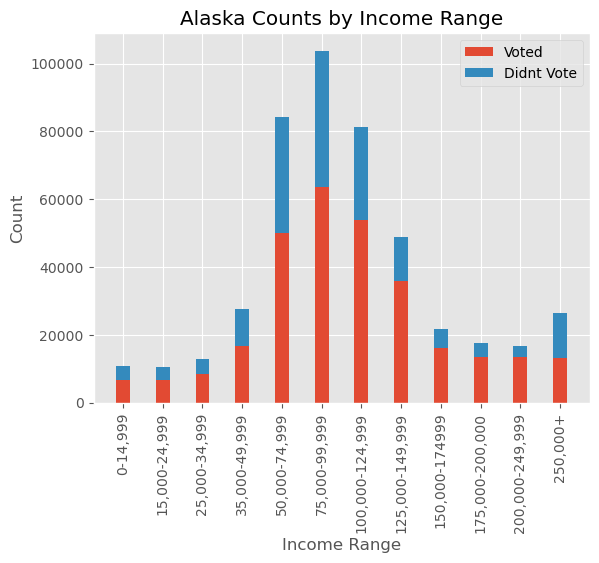

In [73]:
# Define the labels for the income ranges
labels = ['0-14,999', '15,000-24,999', '25,000-34,999', '35,000-49,999', '50,000-74,999', '75,000-99,999', '100,000-124,999', '125,000-149,999', '150,000-174999', '175,000-200,000', '200,000-249,999', '250,000+']

# Define the counts for each income range and whether or not they voted or not
y_counts = [ak_i1y,ak_i2y,ak_i3y,ak_i4y,ak_i5y,ak_i6y,ak_i7y,ak_i8y,ak_i9y,ak_i10y,ak_i11y,ak_i12y]
n_counts = [ak_i1n,ak_i2n,ak_i3n,ak_i4n,ak_i5n,ak_i6n,ak_i7n,ak_i8n,ak_i9n,ak_i10n,ak_i11n,ak_i12n]

# Define the x locations for the bars
x = np.arange(len(labels))

# Define the width of the bars
width = 0.35

# Create the stacked bar chart
fig, ax = plt.subplots()
ax.bar(x, y_counts, width, label='Voted')
ax.bar(x, n_counts, width, bottom=y_counts, label='Didnt Vote')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_xlabel('Income Range')
ax.set_title('Alaska Counts by Income Range')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

plt.show()

Looking at the income range and whether they voted or not, it seems that those with very low income and those with very high income tend to vote more than not.

# Nevada

In [74]:
# cleaned is changing the string type to an int. And also General_2020 which contains null for didn't vote so we will change that to "N" for computing
df_nv_cleaned = df_nv.filter(col("CommercialData_EstimatedHHIncomeAmount").isNotNull()) \
                     .withColumn("CommercialData_EstimatedHHIncomeAmount",
                                 regexp_replace(col("CommercialData_EstimatedHHIncomeAmount"), "[\$,]", "").cast("int")) \
                     .na.fill("N", subset=["General_2020"])
# these are the amounts for each range of income for Nevada that voted
nv_i1y = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 0) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 14999) & (df_nv_cleaned['General_2020'] == 'Y')).count()
nv_i2y = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 15000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 24999) & (df_nv_cleaned['General_2020'] == 'Y')).count()
nv_i3y = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 25000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 34999) & (df_nv_cleaned['General_2020'] == 'Y')).count()
nv_i4y = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 35000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 49999) & (df_nv_cleaned['General_2020'] == 'Y')).count()
nv_i5y = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 50000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 74999) & (df_nv_cleaned['General_2020'] == 'Y')).count()
nv_i6y = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 75000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 99999) & (df_nv_cleaned['General_2020'] == 'Y')).count()
nv_i7y = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 100000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 124999) & (df_nv_cleaned['General_2020'] == 'Y')).count()
nv_i8y = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 125000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 149999) & (df_nv_cleaned['General_2020'] == 'Y')).count()
nv_i9y = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 150000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 174999) & (df_nv_cleaned['General_2020'] == 'Y')).count()
nv_i10y = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 175000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 199999) & (df_nv_cleaned['General_2020'] == 'Y')).count()
nv_i11y = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 200000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 249999) & (df_nv_cleaned['General_2020'] == 'Y')).count()
nv_i12y = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 250000) & (df_nv_cleaned['General_2020'] == 'Y')).count()

In [75]:
# these are the amounts for each range of income for Nevada that didn't vote
nv_i1n = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 0) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 14999) & (df_nv_cleaned['General_2020'] == 'N')).count()
nv_i2n = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 15000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 24999) & (df_nv_cleaned['General_2020'] == 'N')).count()
nv_i3n = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 25000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 34999) & (df_nv_cleaned['General_2020'] == 'N')).count()
nv_i4n = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 35000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 49999) & (df_nv_cleaned['General_2020'] == 'N')).count()
nv_i5n = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 50000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 74999) & (df_nv_cleaned['General_2020'] == 'N')).count()
nv_i6n = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 75000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 99999) & (df_nv_cleaned['General_2020'] == 'N')).count()
nv_i7n = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 100000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 124999) & (df_nv_cleaned['General_2020'] == 'N')).count()
nv_i8n = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 125000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 149999) & (df_nv_cleaned['General_2020'] == 'N')).count()
nv_i9n = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 150000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 174999) & (df_nv_cleaned['General_2020'] == 'N')).count()
nv_i10n = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 175000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 199999) & (df_nv_cleaned['General_2020'] == 'N')).count()
nv_i11n = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 200000) & (df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 249999) & (df_nv_cleaned['General_2020'] == 'N')).count()
nv_i12n = df_nv_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nv_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 250000) & (df_nv_cleaned['General_2020'] == 'Y'))

In [76]:
print(nv_i12n)

DataFrame[CommercialData_EstimatedHHIncomeAmount: int, General_2020: string]


This value is undefined, that just means that within the nevada dataset there's no data for those that make more than $250,000 and didn't vote. To avoid causing issues, let's assign 0 to it.

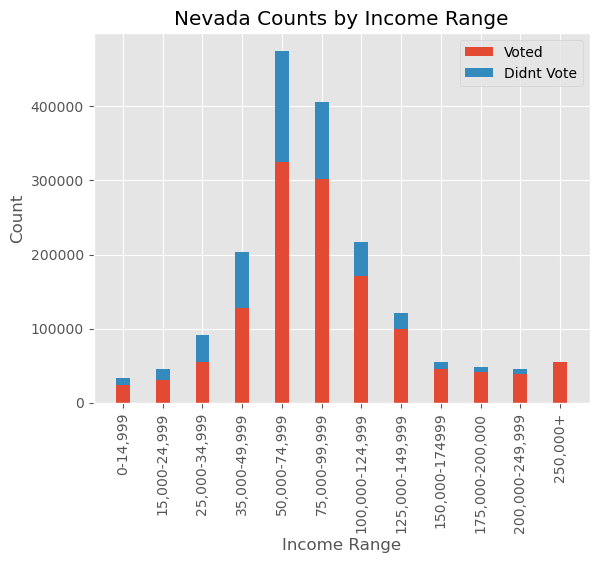

In [77]:
# Define the labels for the income ranges
labels = ['0-14,999', '15,000-24,999', '25,000-34,999', '35,000-49,999', '50,000-74,999', '75,000-99,999', '100,000-124,999', '125,000-149,999', '150,000-174999', '175,000-200,000', '200,000-249,999', '250,000+']
nv_i12n = 0
# Define the counts for each income range and whether or not they voted or not
y_counts = [nv_i1y,nv_i2y,nv_i3y,nv_i4y,nv_i5y,nv_i6y,nv_i7y,nv_i8y,nv_i9y,nv_i10y,nv_i11y,nv_i12y]
n_counts = [nv_i1n,nv_i2n,nv_i3n,nv_i4n,nv_i5n,nv_i6n,nv_i7n,nv_i8n,nv_i9n,nv_i10n,nv_i11n,nv_i12n]

# Define the x locations for the bars
x = np.arange(len(labels))

# Define the width of the bars
width = 0.35

# Create the stacked bar chart
fig, ax = plt.subplots()
ax.bar(x, y_counts, width, label='Voted')
ax.bar(x, n_counts, width, bottom=y_counts, label='Didnt Vote')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_xlabel('Income Range')
ax.set_title('Nevada Counts by Income Range')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

plt.show()

For Nevada, an extreme is seen towards the high income range where a vast majority of people voted

# New Jersey

In [78]:
df_nj_cleaned = df_nj.filter(col("CommercialData_EstimatedHHIncomeAmount").isNotNull()) \
                     .withColumn("CommercialData_EstimatedHHIncomeAmount",
                                 regexp_replace(col("CommercialData_EstimatedHHIncomeAmount"), "[\$,]", "").cast("int")) \
                     .na.fill("N", subset=["General_2020"])
# these are the amounts for each range of income for New Jersey that voted
nj_i1y = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 0) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 14999) & (df_nj_cleaned['General_2020'] == 'Y')).count()
nj_i2y = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 15000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 24999) & (df_nj_cleaned['General_2020'] == 'Y')).count()
nj_i3y = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 25000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 34999) & (df_nj_cleaned['General_2020'] == 'Y')).count()
nj_i4y = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 35000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 49999) & (df_nj_cleaned['General_2020'] == 'Y')).count()
nj_i5y = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 50000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 74999) & (df_nj_cleaned['General_2020'] == 'Y')).count()
nj_i6y = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 75000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 99999) & (df_nj_cleaned['General_2020'] == 'Y')).count()
nj_i7y = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 100000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 124999) & (df_nj_cleaned['General_2020'] == 'Y')).count()
nj_i8y = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 125000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 149999) & (df_nj_cleaned['General_2020'] == 'Y')).count()
nj_i9y = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 150000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 174999) & (df_nj_cleaned['General_2020'] == 'Y')).count()
nj_i10y = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 175000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 199999) & (df_nj_cleaned['General_2020'] == 'Y')).count()
nj_i11y = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 200000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 249999) & (df_nj_cleaned['General_2020'] == 'Y')).count()
nj_i12y = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 250000) & (df_nj_cleaned['General_2020'] == 'Y')).count()

In [79]:
# these are the amounts for each range of income for New Jersey that didn't vote
nj_i1n = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 0) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 14999) & (df_nj_cleaned['General_2020'] == 'N')).count()
nj_i2n = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 15000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 24999) & (df_nj_cleaned['General_2020'] == 'N')).count()
nj_i3n = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 25000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 34999) & (df_nj_cleaned['General_2020'] == 'N')).count()
nj_i4n = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 35000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 49999) & (df_nj_cleaned['General_2020'] == 'N')).count()
nj_i5n = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 50000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 74999) & (df_nj_cleaned['General_2020'] == 'N')).count()
nj_i6n = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 75000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 99999) & (df_nj_cleaned['General_2020'] == 'N')).count()
nj_i7n = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 100000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 124999) & (df_nj_cleaned['General_2020'] == 'N')).count()
nj_i8n = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 125000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 149999) & (df_nj_cleaned['General_2020'] == 'N')).count()
nj_i9n = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 150000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 174999) & (df_nj_cleaned['General_2020'] == 'N')).count()
nj_i10n = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 175000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 199999) & (df_nj_cleaned['General_2020'] == 'N')).count()
nj_i11n = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 200000) & (df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 249999) & (df_nj_cleaned['General_2020'] == 'N')).count()
nj_i12n = df_nj_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_nj_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 250000) & (df_nj_cleaned['General_2020'] == 'Y'))

In [80]:
print(nj_i12n)

DataFrame[CommercialData_EstimatedHHIncomeAmount: int, General_2020: string]


Same here, let's also just set it to equal 0

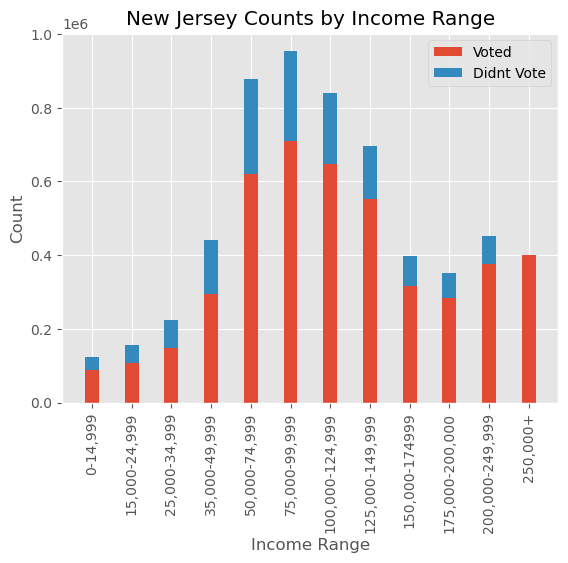

In [81]:
# Define the labels for the income ranges
labels = ['0-14,999', '15,000-24,999', '25,000-34,999', '35,000-49,999', '50,000-74,999', '75,000-99,999', '100,000-124,999', '125,000-149,999', '150,000-174999', '175,000-200,000', '200,000-249,999', '250,000+']
# Define the counts for each income range and whether they voted or not
nj_i12n = 0
y_counts = [nj_i1y,nj_i2y,nj_i3y,nj_i4y,nj_i5y,nj_i6y,nj_i7y,nj_i8y,nj_i9y,nj_i10y,nj_i11y,nj_i12y]
n_counts = [nj_i1n,nj_i2n,nj_i3n,nj_i4n,nj_i5n,nj_i6n,nj_i7n,nj_i8n,nj_i9n,nj_i10n,nj_i11n,nj_i12n]

# Define the x locations for the bars
x = np.arange(len(labels))

# Define the width of the bars
width = 0.35

# Create the stacked bar chart
fig, ax = plt.subplots()
ax.bar(x, y_counts, width, label='Voted')
ax.bar(x, n_counts, width, bottom=y_counts, label='Didnt Vote')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_xlabel('Income Range')
ax.set_title('New Jersey Counts by Income Range')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

plt.show()

For new jersey as well, it seems that people with very little income/very high income tend to vote a little more than those in the middle

# Washington

In [ ]:
df_wa_cleaned = df_wa.filter(col("CommercialData_EstimatedHHIncomeAmount").isNotNull()) \
                     .withColumn("CommercialData_EstimatedHHIncomeAmount",
                                 regexp_replace(col("CommercialData_EstimatedHHIncomeAmount"), "[\$,]", "").cast("int")) \
                     .na.fill("N", subset=["General_2020"])
# these are the amounts for each range of income for Washington that voted
wa_i1y = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 0) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 14999) & (df_wa_cleaned['General_2020'] == 'Y')).count()
wa_i2y = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 15000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 24999) & (df_wa_cleaned['General_2020'] == 'Y')).count()
wa_i3y = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 25000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 34999) & (df_wa_cleaned['General_2020'] == 'Y')).count()
wa_i4y = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 35000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 49999) & (df_wa_cleaned['General_2020'] == 'Y')).count()
wa_i5y = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 50000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 74999) & (df_wa_cleaned['General_2020'] == 'Y')).count()
wa_i6y = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 75000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 99999) & (df_wa_cleaned['General_2020'] == 'Y')).count()
wa_i7y = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 100000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 124999) & (df_wa_cleaned['General_2020'] == 'Y')).count()
wa_i8y = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 125000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 149999) & (df_wa_cleaned['General_2020'] == 'Y')).count()
wa_i9y = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 150000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 174999) & (df_wa_cleaned['General_2020'] == 'Y')).count()
wa_i10y = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 175000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 199999) & (df_wa_cleaned['General_2020'] == 'Y')).count()
wa_i11y = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 200000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 249999) & (df_wa_cleaned['General_2020'] == 'Y')).count()
wa_i12y = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 250000) & (df_wa_cleaned['General_2020'] == 'Y')).count()

In [ ]:
# these are the amounts for each range of income for Washington that didn't vote
wa_i1n = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 0) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 14999) & (df_wa_cleaned['General_2020'] == 'N')).count()
wa_i2n = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 15000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 24999) & (df_wa_cleaned['General_2020'] == 'N')).count()
wa_i3n = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 25000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 34999) & (df_wa_cleaned['General_2020'] == 'N')).count()
wa_i4n = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 35000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 49999) & (df_wa_cleaned['General_2020'] == 'N')).count()
wa_i5n = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 50000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 74999) & (df_wa_cleaned['General_2020'] == 'N')).count()
wa_i6n = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 75000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 99999) & (df_wa_cleaned['General_2020'] == 'N')).count()
wa_i7n = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 100000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 124999) & (df_wa_cleaned['General_2020'] == 'N')).count()
wa_i8n = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 125000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 149999) & (df_wa_cleaned['General_2020'] == 'N')).count()
wa_i9n = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 150000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 174999) & (df_wa_cleaned['General_2020'] == 'N')).count()
wa_i10n = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 175000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 199999) & (df_wa_cleaned['General_2020'] == 'N')).count()
wa_i11n = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 200000) & (df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] <= 249999) & (df_wa_cleaned['General_2020'] == 'N')).count()
wa_i12n = df_wa_cleaned.select('CommercialData_EstimatedHHIncomeAmount', 'General_2020').filter((df_wa_cleaned['CommercialData_EstimatedHHIncomeAmount'] >= 250000) & (df_wa_cleaned['General_2020'] == 'Y'))

In [ ]:
print(wa_i12n)

DataFrame[CommercialData_EstimatedHHIncomeAmount: int, General_2020: string]


Same here, let's change it to 0.

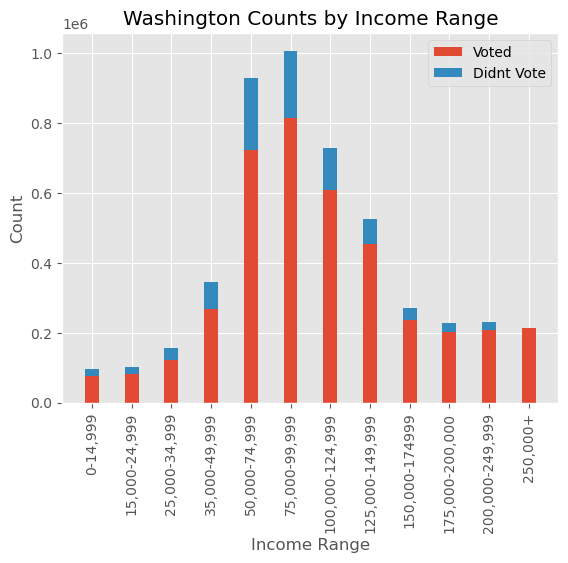

In [ ]:
# Define the labels for the income ranges
labels = ['0-14,999', '15,000-24,999', '25,000-34,999', '35,000-49,999', '50,000-74,999', '75,000-99,999', '100,000-124,999', '125,000-149,999', '150,000-174999', '175,000-200,000', '200,000-249,999', '250,000+']
# Define the counts for each income range and whether they voted or not
wa_i12n = 0
y_counts = [wa_i1y,wa_i2y,wa_i3y,wa_i4y,wa_i5y,wa_i6y,wa_i7y,wa_i8y,wa_i9y,wa_i10y,wa_i11y,wa_i12y]
n_counts = [wa_i1n,wa_i2n,wa_i3n,wa_i4n,wa_i5n,wa_i6n,wa_i7n,wa_i8n,wa_i9n,wa_i10n,wa_i11n,wa_i12n]

# Define the x locations for the bars
x = np.arange(len(labels))

# Define the width of the bars
width = 0.35

# Create the stacked bar chart
fig, ax = plt.subplots()
ax.bar(x, y_counts, width, label='Voted')
ax.bar(x, n_counts, width, bottom=y_counts, label='Didnt Vote')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_xlabel('Income Range')
ax.set_title('Washington Counts by Income Range')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90) # rotate the x-axis labels by 90 degrees
ax.legend()

plt.show()

Same with Washington, those that make very little money and those that make alot of money tend to vote more than their middle class counterparts

## Correlation
With all of these states, a similar pattern that can be seen is that those in the low and high income class tend to vote more. There could be several reasons for this. One of which is political engagement. Those with low income may feel more motivated to vote because the results of the voting affects them directly. They may be more reliant on public services and thus more aware of political issues that impact them. The way that political engagement affects those with higher income is because they have greater resources to contribute to political campaigns and causes. And many might be looking for candidates that support lower taxes in order to keep more of the money they make for themselves.

## How this data could help campaigning efforts
By having an idea on voter turnout based on income level, campaigners who wish to increase the amount of people that vote could target those areas in which a majority of middle class people live. And for those candidates who wishes to gain more votes, they could change their policies to the ones that low income/high income people would appreciate more as their voter turnout is higher than those in the middle class.

# Child Presence and Voter Turnout

## Alaska

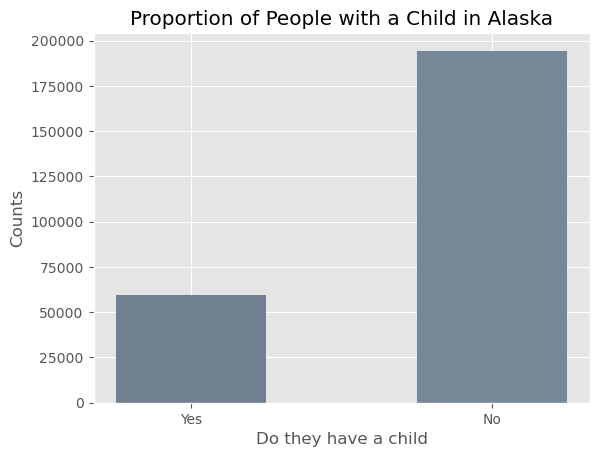

In [ ]:
# Have a child or not
# Results are 'Modeled Not as Likely to have a child', 'Not Likely to have a child', 'Modeleed Likely to have a child'
childLikeliness_ak = df_ak.select('CommercialData_PresenceOfChildrenCode').where(F.col("CommercialData_PresenceOfChildrenCode")!="Known Data").dropna().toPandas()
childLikeliness_ak = childLikeliness_ak.replace('Modeled Not as Likely to have a child', 'Not Likely to have a child')
child_ak = {
    'Yes': len(childLikeliness_ak[childLikeliness_ak['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child']),
    'No': len(childLikeliness_ak[childLikeliness_ak['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child']) 
    }

xChild = list(child_ak.keys())
yChild = list(child_ak.values())
plt.bar(xChild, yChild, color = ['slategray', 'lightslategray'], width = .5)
plt.xlabel('Do they have a child')
plt.ylabel('Counts')
plt.title('Proportion of People with a Child in Alaska')
plt.show()

In [106]:
child_presence_voting = df_ak.select('CommercialData_PresenceOfChildrenCode', 'General_2020').fillna('No')
child_presence_voting = child_presence_voting.replace('Modeled Not as Likely to have a child', 'Not Likely to have a child')

child_voted = child_presence_voting.filter((child_presence_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_voting['General_2020']=='Y')).count()

child_not_voted = child_presence_voting.filter((child_presence_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_voting['General_2020']=='No')).count()

no_child_voted = child_presence_voting.filter((child_presence_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_voting['General_2020']=='Y')).count()

no_child_not_voted = child_presence_voting.filter((child_presence_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_voting['General_2020']=='No')).count()



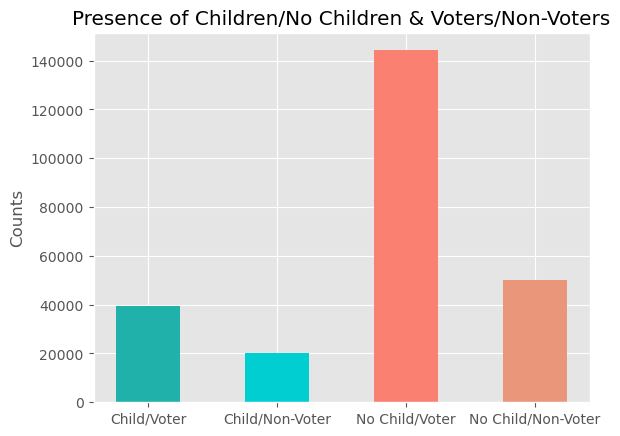

In [107]:
cv = {'Child/Voter': child_voted, 'Child/Non-Voter': child_not_voted, 'No Child/Voter': no_child_voted, 'No Child/Non-Voter': no_child_not_voted}
x_cv = list(cv.keys())
y_cv = list(cv.values())


plt.bar(x_cv, y_cv, width = .5, color = [ 'lightseagreen','darkturquoise', 'salmon','darksalmon'])
plt.ylabel('Counts')
plt.title('Presence of Children/No Children & Voters/Non-Voters')
plt.show()

The majority of people with child presence vs no child presence vote, but it seems a larger proportion of people vote who have no child presence. We'll examine this further.

In [ ]:
# Percent of voters with child presence
print(child_voted/(child_voted+child_not_voted) * 100)

# Percent of voters with no child presence
print(no_child_voted/(no_child_voted + no_child_not_voted) * 100)

65.89480038230018
74.17132397929016


65.89% of people with a child presence vote compared to 74.17% of people with no child presence who vote. From this, it looks like presence of children in Alaska could have an impact on voter turnout.

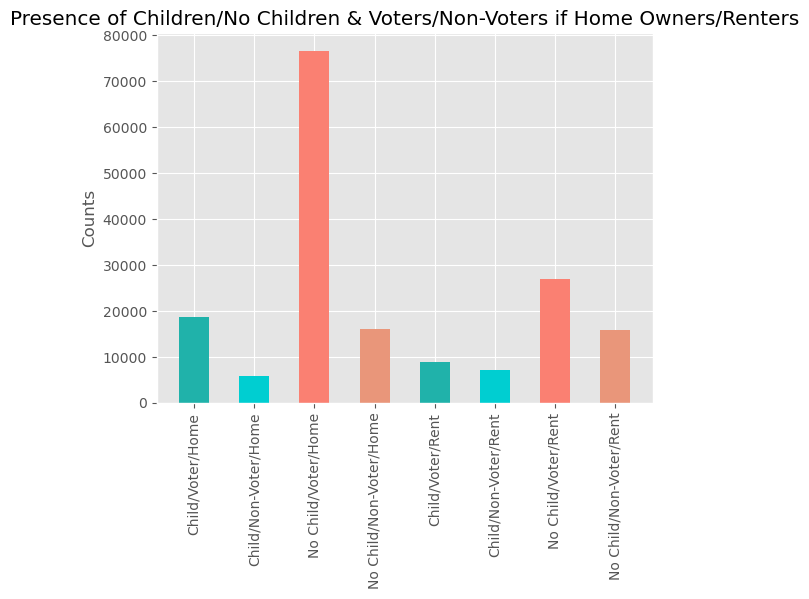

In [ ]:
child_presence_home_voting = df_ak.select('CommercialData_PresenceOfChildrenCode', 'General_2020', 'CommercialDataLL_Home_Owner_Or_Renter').fillna('No')
child_presence_home_voting = child_presence_home_voting.replace('Modeled Not as Likely to have a child', 'Not Likely to have a child')


child_voted_home = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_home_voting['General_2020']=='Y') & (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner')).count()

child_not_voted_home = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_home_voting['General_2020']=='No')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner')).count()

no_child_voted_home = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_home_voting['General_2020']=='Y')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner')).count()

no_child_not_voted_home = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_home_voting['General_2020']=='No')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner')).count()

child_voted_rent = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_home_voting['General_2020']=='Y')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter')).count()

child_not_voted_rent = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_home_voting['General_2020']=='No')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter')).count()

no_child_voted_rent = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_home_voting['General_2020']=='Y')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter')).count()

no_child_not_voted_rent = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_home_voting['General_2020']=='No')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter')).count()


cv = {'Child/Voter/Home': child_voted_home, 'Child/Non-Voter/Home': child_not_voted_home, 'No Child/Voter/Home': no_child_voted_home, 'No Child/Non-Voter/Home': no_child_not_voted_home, 
      'Child/Voter/Rent': child_voted_rent, 'Child/Non-Voter/Rent': child_not_voted_rent, 'No Child/Voter/Rent': no_child_voted_rent, 'No Child/Non-Voter/Rent': no_child_not_voted_rent}
x_cv = list(cv.keys())
y_cv = list(cv.values())


plt.bar(x_cv, y_cv, width = .5, color = [ 'lightseagreen','darkturquoise', 'salmon','darksalmon', 'lightseagreen','darkturquoise', 'salmon','darksalmon'])
plt.ylabel('Counts')
plt.title('Presence of Children/No Children & Voters/Non-Voters if Home Owners/Renters')
plt.xticks(rotation='vertical')
plt.show()

Child Presence with homeowners vs renters does not seem to have an effect on voter turnout

## Nevada

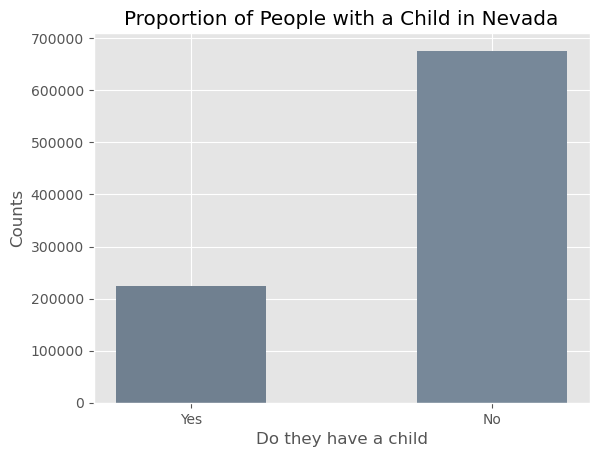

In [ ]:
# Have a child or not
# Results are 'Modeled Not as Likely to have a child', 'Not Likely to have a child', 'Modeleed Likely to have a child'
childLikeliness_nv = df_nv.select('CommercialData_PresenceOfChildrenCode').where(F.col("CommercialData_PresenceOfChildrenCode")!="Known Data").dropna().toPandas()
childLikeliness_nv = childLikeliness_nv.replace('Modeled Not as Likely to have a child', 'Not Likely to have a child')
child_nv = {
    'Yes': len(childLikeliness_nv[childLikeliness_nv['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child']),
    'No': len(childLikeliness_nv[childLikeliness_nv['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child']) 
    }

xChild = list(child_nv.keys())
yChild = list(child_nv.values())
plt.bar(xChild, yChild, color = ['slategray', 'lightslategray'], width = .5)
plt.xlabel('Do they have a child')
plt.ylabel('Counts')
plt.title('Proportion of People with a Child in Nevada')
plt.show()

In [ ]:
child_presence_voting = df_nv.select('CommercialData_PresenceOfChildrenCode', 'General_2020').fillna('No')
child_presence_voting = child_presence_voting.replace('Modeled Not as Likely to have a child', 'Not Likely to have a child')

child_voted = child_presence_voting.filter((child_presence_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_voting['General_2020']=='Y')).count()

child_not_voted = child_presence_voting.filter((child_presence_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_voting['General_2020']=='No')).count()

no_child_voted = child_presence_voting.filter((child_presence_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_voting['General_2020']=='Y')).count()

no_child_not_voted = child_presence_voting.filter((child_presence_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_voting['General_2020']=='No')).count()

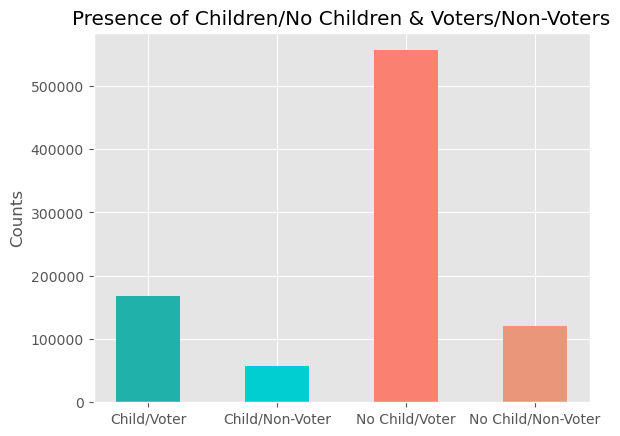

In [ ]:
cv = {'Child/Voter': child_voted, 'Child/Non-Voter': child_not_voted, 'No Child/Voter': no_child_voted, 'No Child/Non-Voter': no_child_not_voted}
x_cv = list(cv.keys())
y_cv = list(cv.values())


plt.bar(x_cv, y_cv, width = .5, color = [ 'lightseagreen','darkturquoise', 'salmon','darksalmon'])
plt.ylabel('Counts')
plt.title('Presence of Children/No Children & Voters/Non-Voters')
plt.show()

The majority of people with child presence vs no child presence vote, but it seems a slightly larger proportion of people vote who have no child presence. We'll examine this further.

In [ ]:
# Percent of voters with child presence
print(child_voted/(child_voted+child_not_voted) * 100)

# Percent of voters with no child presence
print(no_child_voted/(no_child_voted + no_child_not_voted) * 100)

74.50908864431058
82.270960528184


74.51% of people with a child presence vote compared to 82.27% of people with no child presence who vote. From this, it looks like presence of children in Nevada could have an impact on voter turnout.

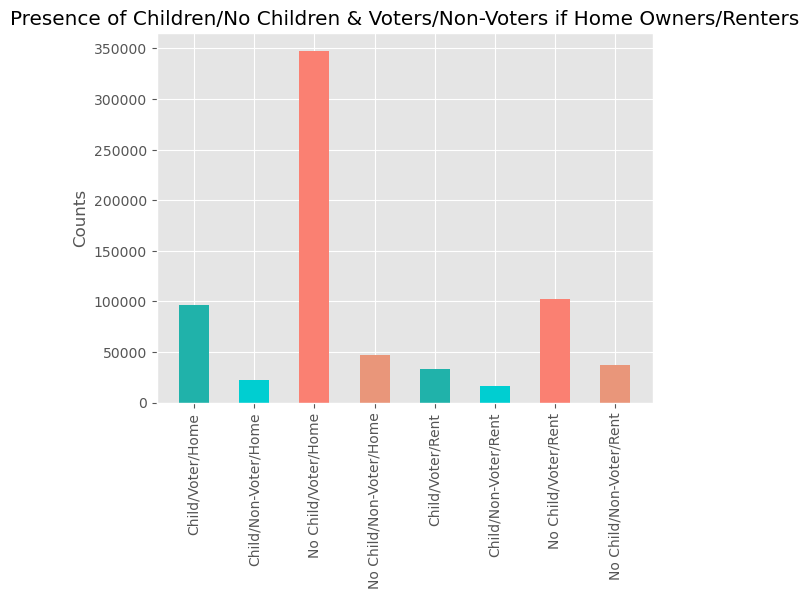

In [ ]:
child_presence_home_voting = df_nv.select('CommercialData_PresenceOfChildrenCode', 'General_2020', 'CommercialDataLL_Home_Owner_Or_Renter').fillna('No')
child_presence_home_voting = child_presence_home_voting.replace('Modeled Not as Likely to have a child', 'Not Likely to have a child')


child_voted_home = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_home_voting['General_2020']=='Y') & (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner')).count()

child_not_voted_home = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_home_voting['General_2020']=='No')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner')).count()

no_child_voted_home = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_home_voting['General_2020']=='Y')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner')).count()

no_child_not_voted_home = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_home_voting['General_2020']=='No')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner')).count()

child_voted_rent = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_home_voting['General_2020']=='Y')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter')).count()

child_not_voted_rent = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_home_voting['General_2020']=='No')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter')).count()

no_child_voted_rent = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_home_voting['General_2020']=='Y')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter')).count()

no_child_not_voted_rent = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_home_voting['General_2020']=='No')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter')).count()


cv = {'Child/Voter/Home': child_voted_home, 'Child/Non-Voter/Home': child_not_voted_home, 'No Child/Voter/Home': no_child_voted_home, 'No Child/Non-Voter/Home': no_child_not_voted_home, 
      'Child/Voter/Rent': child_voted_rent, 'Child/Non-Voter/Rent': child_not_voted_rent, 'No Child/Voter/Rent': no_child_voted_rent, 'No Child/Non-Voter/Rent': no_child_not_voted_rent}
x_cv = list(cv.keys())
y_cv = list(cv.values())


plt.bar(x_cv, y_cv, width = .5, color = [ 'lightseagreen','darkturquoise', 'salmon','darksalmon', 'lightseagreen','darkturquoise', 'salmon','darksalmon'])
plt.ylabel('Counts')
plt.title('Presence of Children/No Children & Voters/Non-Voters if Home Owners/Renters')
plt.xticks(rotation='vertical')
plt.show()

Child Presence with homeowners vs renters does not seem to have an effect on voter turnout

## New Jersey

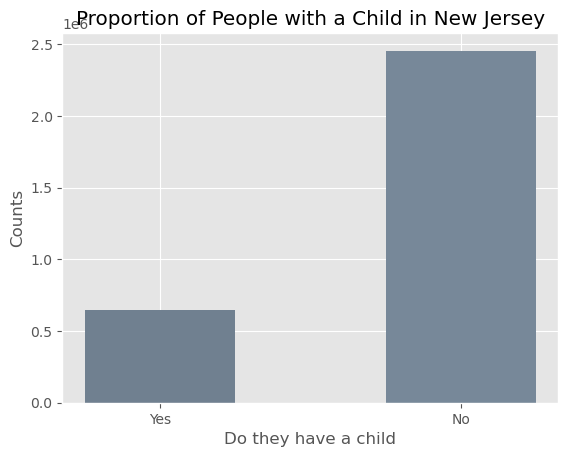

In [ ]:
# Have a child or not
# Results are 'Modeled Not as Likely to have a child', 'Not Likely to have a child', 'Modeleed Likely to have a child'
childLikeliness_nj = df_nj.select('CommercialData_PresenceOfChildrenCode').where(F.col("CommercialData_PresenceOfChildrenCode")!="Known Data").dropna().toPandas()
childLikeliness_nj = childLikeliness_nj.replace('Modeled Not as Likely to have a child', 'Not Likely to have a child')
child_nj = {
    'Yes': len(childLikeliness_nj[childLikeliness_nj['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child']),
    'No': len(childLikeliness_nj[childLikeliness_nj['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child']) 
    }

xChild = list(child_nj.keys())
yChild = list(child_nj.values())
plt.bar(xChild, yChild, color = ['slategray', 'lightslategray'], width = .5)
plt.xlabel('Do they have a child')
plt.ylabel('Counts')
plt.title('Proportion of People with a Child in New Jersey')
plt.show()

In [ ]:
child_presence_voting = df_nj.select('CommercialData_PresenceOfChildrenCode', 'General_2020').fillna('No')
child_presence_voting = child_presence_voting.replace('Modeled Not as Likely to have a child', 'Not Likely to have a child')

child_voted = child_presence_voting.filter((child_presence_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_voting['General_2020']=='Y')).count()

child_not_voted = child_presence_voting.filter((child_presence_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_voting['General_2020']=='No')).count()

no_child_voted = child_presence_voting.filter((child_presence_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_voting['General_2020']=='Y')).count()

no_child_not_voted = child_presence_voting.filter((child_presence_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_voting['General_2020']=='No')).count()

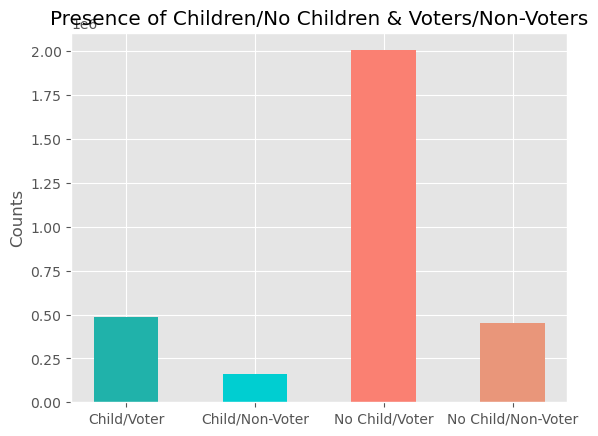

In [ ]:
cv = {'Child/Voter': child_voted, 'Child/Non-Voter': child_not_voted, 'No Child/Voter': no_child_voted, 'No Child/Non-Voter': no_child_not_voted}
x_cv = list(cv.keys())
y_cv = list(cv.values())


plt.bar(x_cv, y_cv, width = .5, color = [ 'lightseagreen','darkturquoise', 'salmon','darksalmon'])
plt.ylabel('Counts')
plt.title('Presence of Children/No Children & Voters/Non-Voters')
plt.show()

The majority of people with child presence vs no child presence vote, and it seems the proportion of people that vote who have no child presence is similar to the proportion that do have a child. We'll examine this further.

In [ ]:
# Percent of voters with child presence
print(child_voted/(child_voted+child_not_voted) * 100)

# Percent of voters with no child presence
print(no_child_voted/(no_child_voted + no_child_not_voted) * 100)

75.40884200105188
81.68295481063276


75.41% of people with child presence vote compared to 81.68% of people with no child presence who vote. From this, it looks like presence of children in New Jersey may have an impact on voter turnout, but less so in New Jersey than Alaska and Nevada.

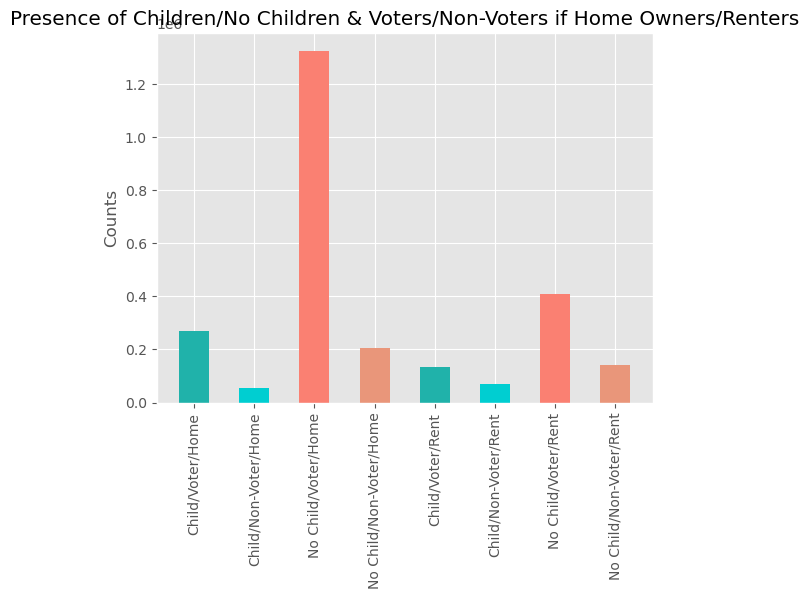

In [ ]:
child_presence_home_voting = df_nj.select('CommercialData_PresenceOfChildrenCode', 'General_2020', 'CommercialDataLL_Home_Owner_Or_Renter').fillna('No')
child_presence_home_voting = child_presence_home_voting.replace('Modeled Not as Likely to have a child', 'Not Likely to have a child')


child_voted_home = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_home_voting['General_2020']=='Y') & (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner')).count()

child_not_voted_home = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_home_voting['General_2020']=='No')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner')).count()

no_child_voted_home = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_home_voting['General_2020']=='Y')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner')).count()

no_child_not_voted_home = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_home_voting['General_2020']=='No')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner')).count()

child_voted_rent = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_home_voting['General_2020']=='Y')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter')).count()

child_not_voted_rent = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_home_voting['General_2020']=='No')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter')).count()

no_child_voted_rent = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_home_voting['General_2020']=='Y')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter')).count()

no_child_not_voted_rent = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_home_voting['General_2020']=='No')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter')).count()


cv = {'Child/Voter/Home': child_voted_home, 'Child/Non-Voter/Home': child_not_voted_home, 'No Child/Voter/Home': no_child_voted_home, 'No Child/Non-Voter/Home': no_child_not_voted_home, 
      'Child/Voter/Rent': child_voted_rent, 'Child/Non-Voter/Rent': child_not_voted_rent, 'No Child/Voter/Rent': no_child_voted_rent, 'No Child/Non-Voter/Rent': no_child_not_voted_rent}
x_cv = list(cv.keys())
y_cv = list(cv.values())


plt.bar(x_cv, y_cv, width = .5, color = [ 'lightseagreen','darkturquoise', 'salmon','darksalmon', 'lightseagreen','darkturquoise', 'salmon','darksalmon'])
plt.ylabel('Counts')
plt.title('Presence of Children/No Children & Voters/Non-Voters if Home Owners/Renters')
plt.xticks(rotation='vertical')
plt.show()

Child Presence with homeowners vs renters does not seem to have an effect on voter turnout

## Washington

23/03/22 05:40:29 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 1 for reason Container marked as failed: container_1679457713853_0002_01_000001 on host: bigcluster-w-1.c.group23-final.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/03/22 05:40:29 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 3 for reason Container marked as failed: container_1679457713853_0002_01_000004 on host: bigcluster-w-1.c.group23-final.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/03/22 05:40:29 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 1 on bigcluster-w-1.c.group23-final.internal: Container marked as failed: container_1679457713853_0002_01_000001 on host: bigcluster-w-1.c.group23-final.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/0

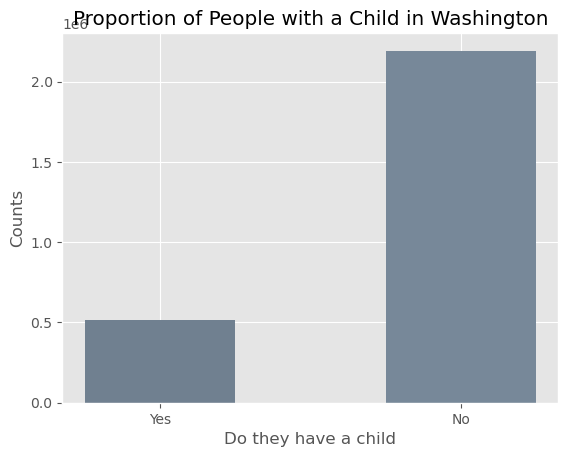

In [ ]:
# Have a child or not
# Results are 'Modeled Not as Likely to have a child', 'Not Likely to have a child', 'Modeleed Likely to have a child'
childLikeliness_wa = df_wa.select('CommercialData_PresenceOfChildrenCode').where(F.col("CommercialData_PresenceOfChildrenCode")!="Known Data").dropna().toPandas()
childLikeliness_wa = childLikeliness_wa.replace('Modeled Not as Likely to have a child', 'Not Likely to have a child')
child_wa = {
    'Yes': len(childLikeliness_wa[childLikeliness_wa['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child']),
    'No': len(childLikeliness_wa[childLikeliness_wa['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child']) 
    }

xChild = list(child_wa.keys())
yChild = list(child_wa.values())
plt.bar(xChild, yChild, color = ['slategray', 'lightslategray'], width = .5)
plt.xlabel('Do they have a child')
plt.ylabel('Counts')
plt.title('Proportion of People with a Child in Washington')
plt.show()

In [ ]:
child_presence_voting = df_wa.select('CommercialData_PresenceOfChildrenCode', 'General_2020').fillna('No')
child_presence_voting = child_presence_voting.replace('Modeled Not as Likely to have a child', 'Not Likely to have a child')

child_voted = child_presence_voting.filter((child_presence_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_voting['General_2020']=='Y')).count()

child_not_voted = child_presence_voting.filter((child_presence_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_voting['General_2020']=='No')).count()

no_child_voted = child_presence_voting.filter((child_presence_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_voting['General_2020']=='Y')).count()

no_child_not_voted = child_presence_voting.filter((child_presence_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_voting['General_2020']=='No')).count()

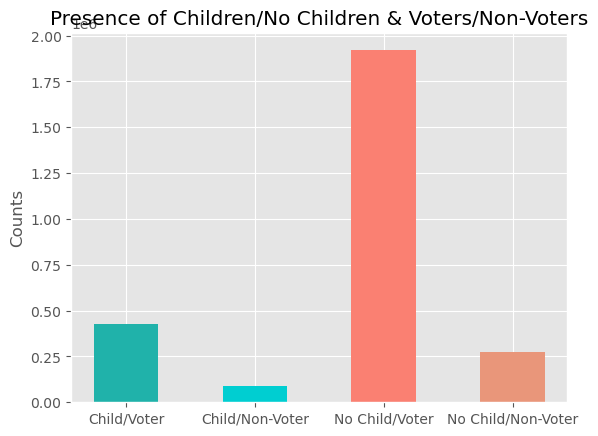

In [ ]:
cv = {'Child/Voter': child_voted, 'Child/Non-Voter': child_not_voted, 'No Child/Voter': no_child_voted, 'No Child/Non-Voter': no_child_not_voted}
x_cv = list(cv.keys())
y_cv = list(cv.values())


plt.bar(x_cv, y_cv, width = .5, color = [ 'lightseagreen','darkturquoise', 'salmon','darksalmon'])
plt.ylabel('Counts')
plt.title('Presence of Children/No Children & Voters/Non-Voters')
plt.show()

The majority of people with child presence vs no child presence vote, and it seems the proportion of people that vote who have no child presence is similar to the proportion that do have a child. We'll examine this further.

In [ ]:
# Percent of voters with child presence
print(child_voted/(child_voted+child_not_voted) * 100)

# Percent of voters with no child presence
print(no_child_voted/(no_child_voted + no_child_not_voted) * 100)

82.81878724286484
87.53556911727493


82.82% of people with child presence vote compared to 87.54% of people with no child presence who vote. From this, it looks like presence of children in Washington could potentially have an impact on voter turnout, but not as much as in Alaska or Nevada.

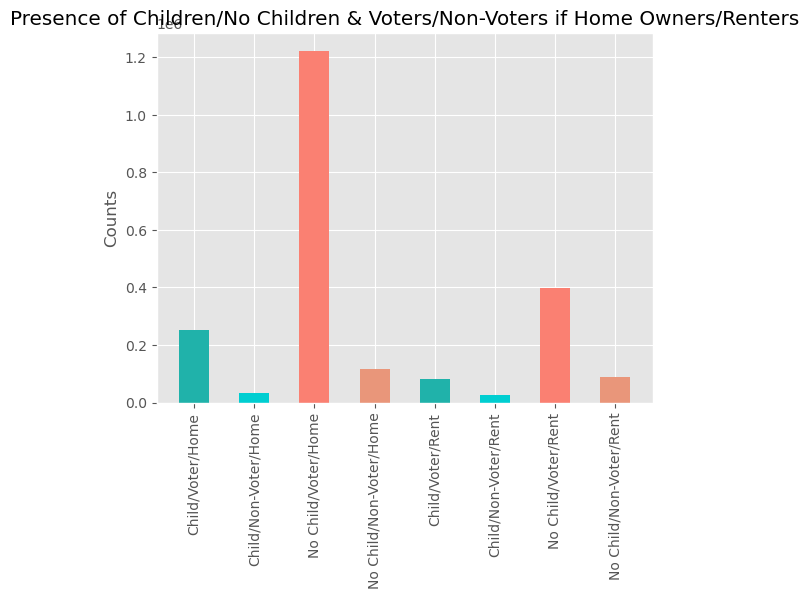

In [ ]:
child_presence_home_voting = df_wa.select('CommercialData_PresenceOfChildrenCode', 'General_2020', 'CommercialDataLL_Home_Owner_Or_Renter').fillna('No')
child_presence_home_voting = child_presence_home_voting.replace('Modeled Not as Likely to have a child', 'Not Likely to have a child')


child_voted_home = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_home_voting['General_2020']=='Y') & (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner')).count()

child_not_voted_home = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_home_voting['General_2020']=='No')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner')).count()

no_child_voted_home = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_home_voting['General_2020']=='Y')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner')).count()

no_child_not_voted_home = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_home_voting['General_2020']=='No')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Homeowner')).count()

child_voted_rent = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_home_voting['General_2020']=='Y')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter')).count()

child_not_voted_rent = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Modeled Likely to have a child') & (child_presence_home_voting['General_2020']=='No')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter')).count()

no_child_voted_rent = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_home_voting['General_2020']=='Y')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter')).count()

no_child_not_voted_rent = child_presence_home_voting.filter((child_presence_home_voting['CommercialData_PresenceOfChildrenCode'] == 'Not Likely to have a child') & (child_presence_home_voting['General_2020']=='No')& (child_presence_home_voting['CommercialDataLL_Home_Owner_Or_Renter'] == 'Likely Renter')).count()


cv = {'Child/Voter/Home': child_voted_home, 'Child/Non-Voter/Home': child_not_voted_home, 'No Child/Voter/Home': no_child_voted_home, 'No Child/Non-Voter/Home': no_child_not_voted_home, 
      'Child/Voter/Rent': child_voted_rent, 'Child/Non-Voter/Rent': child_not_voted_rent, 'No Child/Voter/Rent': no_child_voted_rent, 'No Child/Non-Voter/Rent': no_child_not_voted_rent}
x_cv = list(cv.keys())
y_cv = list(cv.values())


plt.bar(x_cv, y_cv, width = .5, color = [ 'lightseagreen','darkturquoise', 'salmon','darksalmon', 'lightseagreen','darkturquoise', 'salmon','darksalmon'])
plt.ylabel('Counts')
plt.title('Presence of Children/No Children & Voters/Non-Voters if Home Owners/Renters')
plt.xticks(rotation='vertical')
plt.show()

Child Presence with homeowners vs renters does not seem to have an effect on voter turnout

# Logistic Regression to Classify Voter Turnout

Need to add child presence and number of people in household.
NOTE: This model is only for Alaska

In [108]:
# Selecting and filtering the columns I want for the Logistic Regression Model
df_lr_ak = df_ak.select('General_2020', 'CommercialData_HomePurchasePrice', 'CommercialDataLL_Home_Owner_Or_Renter', 'CommercialData_EstimatedHHIncomeAmount',
                        'CommercialData_PresenceOfChildrenCode').fillna('N')
df_lr_ak = df_lr_ak.filter((df_lr_ak['CommercialData_HomePurchasePrice'] != 'N') & (df_lr_ak['CommercialDataLL_Home_Owner_Or_Renter'] != 'N')
                          & (df_lr_ak['CommercialData_EstimatedHHIncomeAmount'] != 'N') & (df_lr_ak['CommercialData_PresenceOfChildrenCode'] != 'Known Data'))  

# removing dollar signs and commas
df_lr_ak = df_lr_ak.withColumn('CommercialData_HomePurchasePrice', regexp_replace(col('CommercialData_HomePurchasePrice'), "[$,]", ""))
df_lr_ak = df_lr_ak.withColumn('CommercialData_EstimatedHHIncomeAmount', regexp_replace(col('CommercialData_EstimatedHHIncomeAmount'), "[$,]", ""))

# converting home price to numeric
df_lr_ak = df_lr_ak.withColumn('CommercialData_HomePurchasePrice', df_lr_ak.CommercialData_HomePurchasePrice.cast('numeric'))
df_lr_ak = df_lr_ak.withColumn('CommercialData_EstimatedHHIncomeAmount', df_lr_ak.CommercialData_EstimatedHHIncomeAmount.cast('numeric'))

df_lr_ak.show(10)
df_lr_ak.printSchema()

+------------+--------------------------------+-------------------------------------+--------------------------------------+-------------------------------------+
|General_2020|CommercialData_HomePurchasePrice|CommercialDataLL_Home_Owner_Or_Renter|CommercialData_EstimatedHHIncomeAmount|CommercialData_PresenceOfChildrenCode|
+------------+--------------------------------+-------------------------------------+--------------------------------------+-------------------------------------+
|           Y|                          186000|                        Likely Renter|                                122000|                 Not Likely to hav...|
|           N|                          362000|                     Likely Homeowner|                                208000|                 Not Likely to hav...|
|           Y|                          415000|                     Likely Homeowner|                                218000|                 Not Likely to hav...|
|           Y|        

In [109]:
# Preparing the dataset to fit the model
supervised = RFormula(formula = 'General_2020 ~ .')
fittedRF = supervised.fit(df_lr_ak)
preparedDF = fittedRF.transform(df_lr_ak)

featureCols = pd.DataFrame(preparedDF.schema['features'].metadata['ml_attr']['attrs']['binary']+
                preparedDF.schema['features'].metadata['ml_attr']['attrs']['numeric']).sort_values('idx')
featureCols = featureCols.set_index('idx')
featureCols.head()

,name
idx,
0,CommercialData_HomePurchasePrice
1,CommercialDataLL_Home_Owner_Or_Renter_Likely H...
2,CommercialData_EstimatedHHIncomeAmount
3,CommercialData_PresenceOfChildrenCode_Not Like...
4,CommercialData_PresenceOfChildrenCode_Modeled ...


In [110]:
# Splitting the transformed data set into train and test sets
random.seed(135)
train, test = preparedDF.randomSplit([0.7, 0.3])

In [114]:
# Instantiating an instance of the logistic regression model
lr = LogisticRegression(labelCol = 'label', featuresCol = 'features')

# fitting the model on the training set
lrMODEL = lr.fit(train)

# passing the test set through our trained model
fittedTest = lrMODEL.transform(test)

23/03/22 06:02:27 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/22 06:02:28 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [115]:
# obtaining the summary
summary = lrMODEL.summary

# train ROC value
print('The Area Under the ROC Curve for the Training Data is', summary.areaUnderROC)

# test ROC value
aucEvaluator = BinaryClassificationEvaluator()\
.setMetricName("areaUnderROC")\
.setRawPredictionCol("prediction")\
.setLabelCol("label")

print('The Area Under the ROC Curve for the Test Data is', aucEvaluator.evaluate(fittedTest))

The Area Under the ROC Curve for the Training Data is 0.595769935223743


The Area Under the ROC Curve for the Test Data is 0.5


## Feature Importance

In [119]:
coefsArray = np.array(lrMODEL.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF.sort_values('coefs', inplace=True)  # Sort them

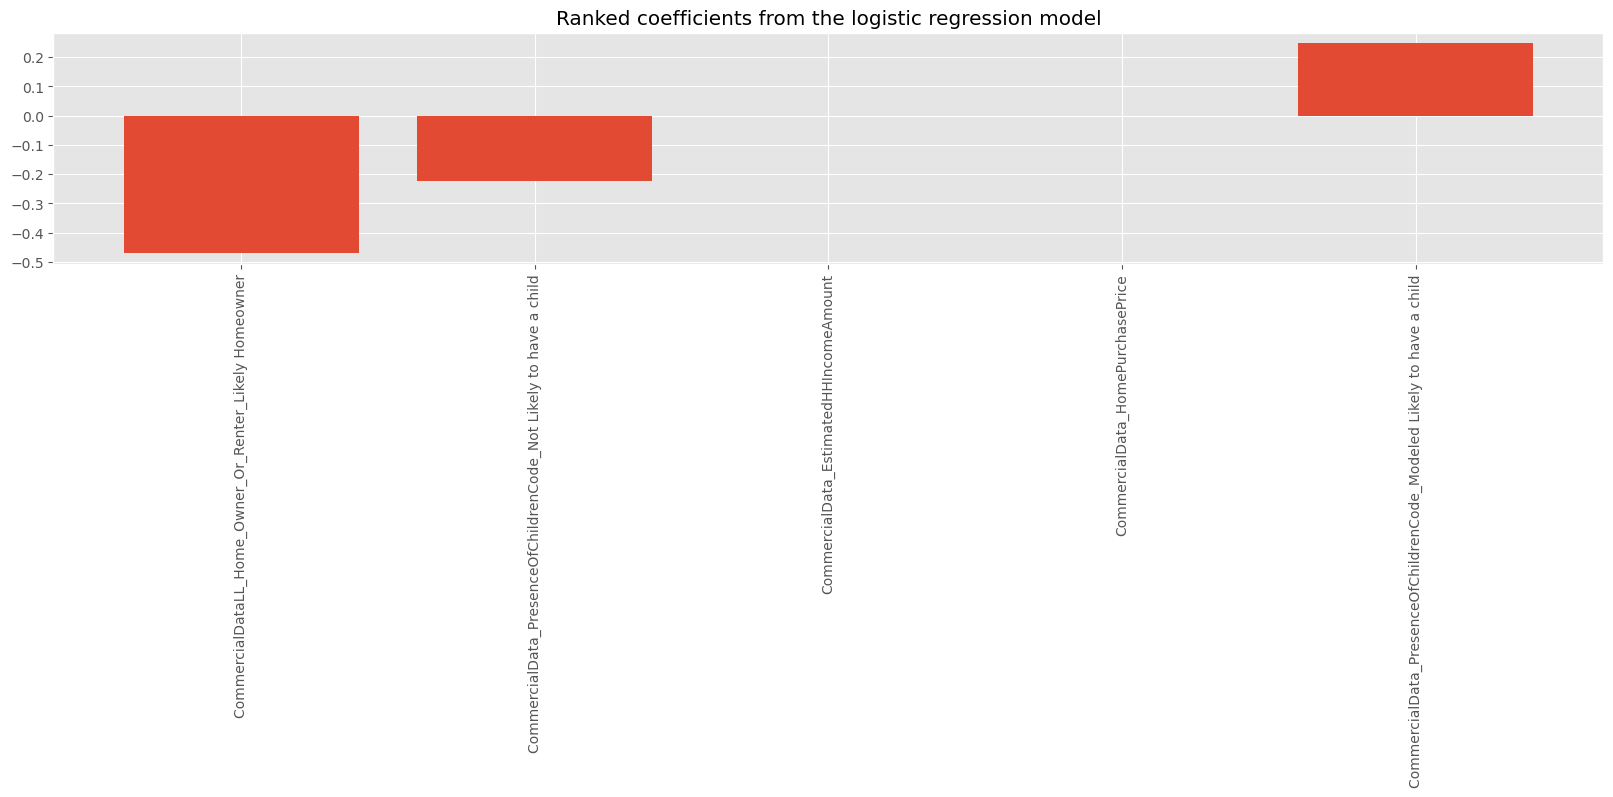

In [120]:
# Plotting Bar Chart
plt.rcParams["figure.figsize"] = (20,3)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()

## ROC Curve

Text(0, 0.5, 'TPR')

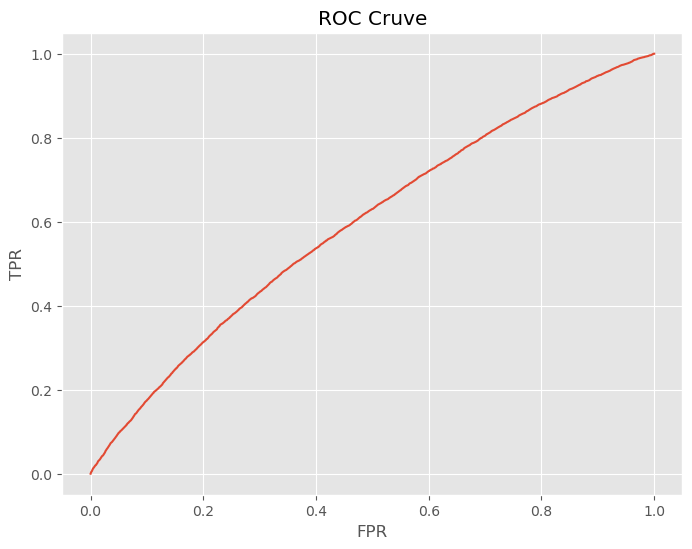

In [118]:
# ROC
roc = summary.roc.toPandas()
plt.rcParams["figure.figsize"] = (8,6)
roc.plot(x='FPR', y='TPR', style='-', legend=False)
plt.title('ROC Cruve')
plt.ylabel('TPR')

As we can see above, our logistic regression model trained on Home Owner or Renter, Income, Home Purchase Price, and child presence was not very successfull. Our test error rate was 0.5 which means the model is like the flip of a coin. This leads us to believe that the variables we explored are not very useful in predicting whether an individual will vote or not. 

# Conclusion

In this report, we analyzed the relationship between voter turnout and income level, house ownership cost, homeownership at the county level, and child presence amongst 4 different states: New Jersey, Nevada, Washington, and Alaska. The intent of this project was to create a model and conclusion on how these demographic factors can help candidates in their future elections strive to improve equity in their electoral process. The analysis of each factor was meticulously explored, and the conclusions of each were as follows. 

At first glance we notice that a significant number of the citizens in the states we researched do not vote, which leads us to think why there is voter disparity. We found that in all four states there are more homeowners than renters, and homeowners tend to vote more than renters. This led us to another question, do people with a higher home price tend to vote more or vice versa? It was found that people among all home prices vote and there is no significant disparity among voters who live in different priced houses. 

Regarding homeownership in counties in regards to voter turnout, in each state, from the barcharts, it was clear that counties with the highest homeownership had the highest voter turnout. Reasons for this correlation can fall into categories of high financial investment, age, and stability. Voters that own homes may be more likely to be involved in policies regarding property and taxes, may be older and feel a sense of responsibility towards the community and country.

For income level, extremes where income is very low or very high is the general group of voters that voted more rather than not voting for all four states. Even more extreme is the group of voters with the highest income where for 2 of the states 100% of them voted. This could be due to the fact that the results of the voting matters more to these people than those people in the middle class. However, it can be seen that generally people across all different income levels tend to vote more than not.
For child presence, we found voting rates with no child presence across the four states to be slightly higher but not significantly. It’s hard to make a determination as to whether child presence is truly the factor that impacts the voting rates or if its other variables that may affect child presence, such as age. When comparing child presence and voter turnout with being a homeowner or renter, the trends for homeowner vs renter were very similar so significance was not concluded. 

We chose income level, house ownership cost, homeownership, and child presence because we believed that these four variables were interconnected in a way that separated voters into distinct groups of votes and patterns in voting behavior. For example, those with high income tend to vote a lot more than those in the middle class. Our hypothesis was that homeowners and high income households would have higher voter turnouts. This hypothesis was supported since the results from the home ownership plot show that homeowners tend to vote more than renters. A possible correlation is that people with high income tend to own homes and are therefore more likely to vote. This is further supported by our plots which show that counties with the highest homeownership had the highest voter turnout. Unfortunately, as we have seen in our plots for child presence, voting rates for those without children were only slightly higher than those who have children. It was not significant enough to generalize whether child presence is an important factor that impacts whether a person votes or not. These results can be used by voting advocates in focusing their resources on a more diverse demographic for a better voting turnout in comparison to general 2020 elections.


# Final Thoughts

This project was the first time for many of us working with a dataset this large. With more than 700 variables and the sheer size of the files, it was difficult to find and choose variables that we wanted to work with. Through exploring the contents of the variables we wanted to use, many had a significant number of null values that it was not feasible to properly deal with the null values. Additionally, there are so many variables to choose from, some may be useful at first sight but there are probably variables that are helpful that we don’t know about. It was also hard drawing more meaningful conclusions about our plots as we lacked knowledge of what to expect when it comes to trends we see. Though we can see small patterns within our data, it was hard coming up with a reason why. More knowledge about subject matter would help when analyzing the data to make more sense of patterns and our results. Overall, this project was a wonderful learning opportunity for all of us to collaborate on and use PySpark, Google Cloud Engine, and Jupyter Notebook for analyzing big datasets.